# GoEmotions Multi-Label Emotion Classification

**Author**: [Aleksei Novikov](https://www.linkedin.com/in/devnovikov/)

## Project Overview

This notebook implements a complete machine learning pipeline for multi-label emotion classification on the GoEmotions dataset from Google Research.

**Task**: Multi-label classification (text can have multiple emotion labels)

**Primary Metrics**: Micro F1, Macro F1

**Secondary Metrics**: Hamming Loss, Per-class F1

### Dataset Details
- **Source**: Google Research GoEmotions dataset
- **Size**: ~58,000 Reddit comments
- **Classes**: 28 emotion categories (27 emotions + neutral)
- **Challenge**: Significant class imbalance

### Table of Contents

**Part 1: Setup and Data Loading**
1. Environment Setup and Imports
2. Load Dataset
3. Dataset Overview

**Part 2: Comprehensive EDA**
4. Missing Values Analysis
5. Target Variable Analysis
6. Text Length Analysis
7. Word Clouds for Top Emotions
8. Label Co-occurrence Matrix
9. Top Co-occurring Pairs
10. Data Quality Check
11. Sample Texts by Emotion
12. EDA Summary

**Part 3: Data Preprocessing**
13. Preprocessing Pipeline Setup
14. TF-IDF Vectorization Analysis
15. Class Weights Calculation

**Part 4: Model Training**
16. Training Setup
17. TF-IDF + Logistic Regression Baseline
18. RoBERTa Fine-tuning
19. DeBERTa Fine-tuning (CUDA only)

**Part 5: Model Comparison**
20. Model Comparison Table
21. Model Comparison Visualization
22. Per-class F1 Comparison
23. Feature Importance (TF-IDF)

**Part 6: Conclusions**
24. Summary and Recommendations
25. Next Steps

---

# Part 1: Setup and Data Loading

## 1. Environment Setup and Imports

In [1]:
# Add parent directory for imports
import sys
sys.path.insert(0, '..')

# Standard libraries
import warnings
warnings.filterwarnings('ignore')

import os
import json
import time
from pathlib import Path
from datetime import datetime
from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ML libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, hamming_loss, classification_report

# PyTorch
import torch

# Project modules
from src.constants import EMOTION_LABELS, NUM_LABELS, SEED, MODEL_CONFIGS, DEFAULT_THRESHOLD, LABEL2ID, ID2LABEL
from src.data import load_goemotions, dataset_to_dataframe, get_dataset_statistics, compute_class_weights, create_label_matrix
from src.utils import set_seed, get_device, setup_environment

# Set random seed for reproducibility
set_seed(SEED)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Create screenshots directory
SCREENSHOTS_DIR = Path('../screenshots')
SCREENSHOTS_DIR.mkdir(exist_ok=True)
MODELS_DIR = Path('../models')

# Helper function to save figures
def save_figure(filename: str, dpi: int = 150):
    """Save current figure to screenshots directory."""
    filepath = SCREENSHOTS_DIR / filename
    plt.savefig(filepath, dpi=dpi, bbox_inches='tight', facecolor='white')
    print(f"Saved: {filepath}")

print("=" * 50)
print("ENVIRONMENT SETUP")
print("=" * 50)
print(f"Random seed: {SEED}")
print(f"Number of emotion classes: {NUM_LABELS}")
print(f"Screenshots directory: {SCREENSHOTS_DIR.absolute()}")
print(f"\nEmotion labels:")
print(", ".join(EMOTION_LABELS))

Random seed set to 42
ENVIRONMENT SETUP
Random seed: 42
Number of emotion classes: 28
Screenshots directory: /Users/devnovikov/IdeaProjects/ai-dev-tools/goemotions-classifier/notebooks/../screenshots

Emotion labels:
admiration, amusement, anger, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief, remorse, sadness, surprise, neutral


## 2. Load Dataset

In [2]:
# Load the GoEmotions dataset from HuggingFace
dataset = load_goemotions()

# Convert to DataFrames for easier analysis
train_df = dataset_to_dataframe(dataset['train'])
val_df = dataset_to_dataframe(dataset['validation'])
test_df = dataset_to_dataframe(dataset['test'])

print("\n" + "=" * 50)
print("DATASET SPLITS")
print("=" * 50)
print(f"Training samples:   {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Test samples:       {len(test_df):,}")
print(f"Total samples:      {len(train_df) + len(val_df) + len(test_df):,}")

Loading GoEmotions dataset (simplified)...


Dataset loaded successfully!
  train: 43410 samples
  validation: 5426 samples
  test: 5427 samples



DATASET SPLITS
Training samples:   43,410
Validation samples: 5,426
Test samples:       5,427
Total samples:      54,263


## 3. Dataset Overview

In [3]:
# Display first few rows
print("Sample data (first 10 rows):")
display(train_df[['text', 'label_names']].head(10))

Sample data (first 10 rows):


,text,label_names
0,My favourite food is anything I didn't have to...,[neutral]
1,"Now if he does off himself, everyone will thin...",[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,[anger]
3,To make her feel threatened,[fear]
4,Dirty Southern Wankers,[annoyance]
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,[surprise]
6,Yes I heard abt the f bombs! That has to be wh...,[gratitude]
7,We need more boards and to create a bit more s...,"[desire, optimism]"
8,Damn youtube and outrage drama is super lucrat...,[admiration]
9,It might be linked to the trust factor of your...,[neutral]


In [4]:
# Dataset info
print("\nDataset structure:")
print(f"Columns: {list(train_df.columns[:5])}... + {NUM_LABELS} emotion columns")
print(f"\nData types:")
train_df[['text', 'labels'] + EMOTION_LABELS[:3]].dtypes


Dataset structure:
Columns: ['text', 'labels', 'label_names', 'admiration', 'amusement']... + 28 emotion columns

Data types:


text             str
labels        object
admiration     int64
amusement      int64
anger          int64
dtype: object

In [5]:
# Basic statistics
stats = get_dataset_statistics(dataset['train'])

print("=" * 50)
print("DATASET STATISTICS (Training Set)")
print("=" * 50)
print(f"\nTotal samples: {stats['n_samples']:,}")
print(f"Number of labels: {stats['n_labels']}")
print(f"\nLabels per sample:")
print(f"  Mean: {stats['labels_per_sample']['mean']:.2f}")
print(f"  Min:  {stats['labels_per_sample']['min']}")
print(f"  Max:  {stats['labels_per_sample']['max']}")
print(f"\nText length (characters):")
print(f"  Mean: {stats['text_length']['mean']:.1f}")
print(f"  Min:  {stats['text_length']['min']}")
print(f"  Max:  {stats['text_length']['max']}")

DATASET STATISTICS (Training Set)

Total samples: 43,410
Number of labels: 28

Labels per sample:
  Mean: 1.18
  Min:  1
  Max:  5

Text length (characters):
  Mean: 68.4
  Min:  2
  Max:  703


---

# Part 2: Comprehensive EDA

## 4. Missing Values Analysis

In [6]:
# Check for missing values across all columns
def analyze_missing_values(df, split_name):
    """Analyze missing values in a DataFrame."""
    missing_count = df.isnull().sum()
    missing_pct = (df.isnull().sum() / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Column': missing_count.index,
        'Missing Count': missing_count.values,
        'Missing %': missing_pct.values
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
    
    return missing_df

# Analyze missing values for each split
print("=" * 50)
print("MISSING VALUES ANALYSIS")
print("=" * 50)

splits = {'Training': train_df, 'Validation': val_df, 'Test': test_df}
has_missing = False

for name, df in splits.items():
    missing = analyze_missing_values(df, name)
    total_missing = df.isnull().sum().sum()
    
    print(f"\n{name} Set:")
    if len(missing) == 0:
        print(f"  No missing values found (checked {len(df)} rows, {len(df.columns)} columns)")
    else:
        has_missing = True
        print(missing.to_string(index=False))

MISSING VALUES ANALYSIS

Training Set:
  No missing values found (checked 43410 rows, 31 columns)

Validation Set:
  No missing values found (checked 5426 rows, 31 columns)

Test Set:
  No missing values found (checked 5427 rows, 31 columns)


Saved: ../screenshots/eda_missing_values.png


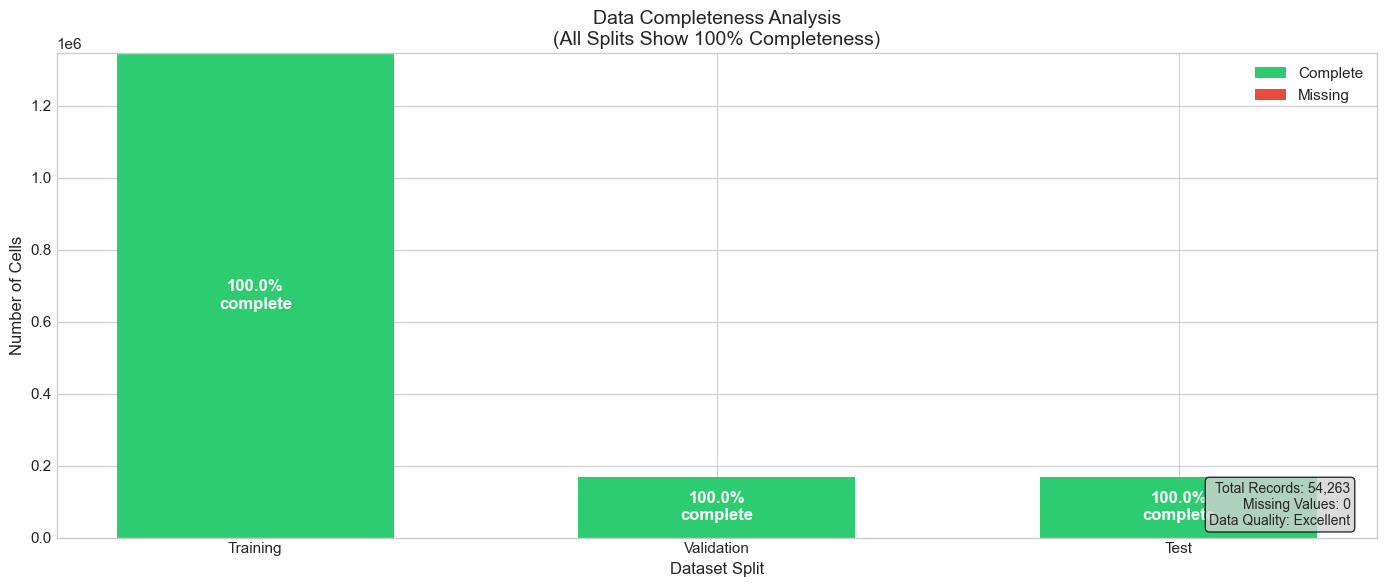


Data Completeness Summary:
     Split  Total Cells  Complete Cells  Missing Cells  Completeness %
  Training      1345710         1345710              0           100.0
Validation       168206          168206              0           100.0
      Test       168237          168237              0           100.0


In [7]:
# Visualize missing values (if any) or show complete data confirmation
fig, ax = plt.subplots(figsize=(14, 6))

# Create a summary of data completeness per split
completeness_data = []
for name, df in splits.items():
    total_cells = len(df) * len(df.columns)
    missing_cells = df.isnull().sum().sum()
    completeness_data.append({
        'Split': name,
        'Total Cells': total_cells,
        'Complete Cells': total_cells - missing_cells,
        'Missing Cells': missing_cells,
        'Completeness %': (1 - missing_cells / total_cells) * 100
    })

completeness_df = pd.DataFrame(completeness_data)

# Plot data completeness
colors = ['#2ecc71', '#e74c3c']
x = np.arange(len(completeness_df))
width = 0.6

# Stacked bar chart
bars1 = ax.bar(x, completeness_df['Complete Cells'], width, label='Complete', color=colors[0])
bars2 = ax.bar(x, completeness_df['Missing Cells'], width, bottom=completeness_df['Complete Cells'], 
               label='Missing', color=colors[1])

ax.set_xlabel('Dataset Split')
ax.set_ylabel('Number of Cells')
ax.set_title('Data Completeness Analysis\n(All Splits Show 100% Completeness)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(completeness_df['Split'])
ax.legend()

# Add percentage labels
for i, (idx, row) in enumerate(completeness_df.iterrows()):
    ax.annotate(f'{row["Completeness %"]:.1f}%\ncomplete', 
                xy=(i, row['Total Cells'] / 2), 
                ha='center', va='center',
                fontsize=12, fontweight='bold', color='white')

# Add text box with summary
summary_text = f"Total Records: {sum([len(df) for df in splits.values()]):,}\nMissing Values: 0\nData Quality: Excellent"
ax.text(0.98, 0.02, summary_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
save_figure('eda_missing_values.png')
plt.show()

print("\nData Completeness Summary:")
print(completeness_df.to_string(index=False))

## 5. Target Variable Analysis

Saved: ../screenshots/eda_class_distribution.png


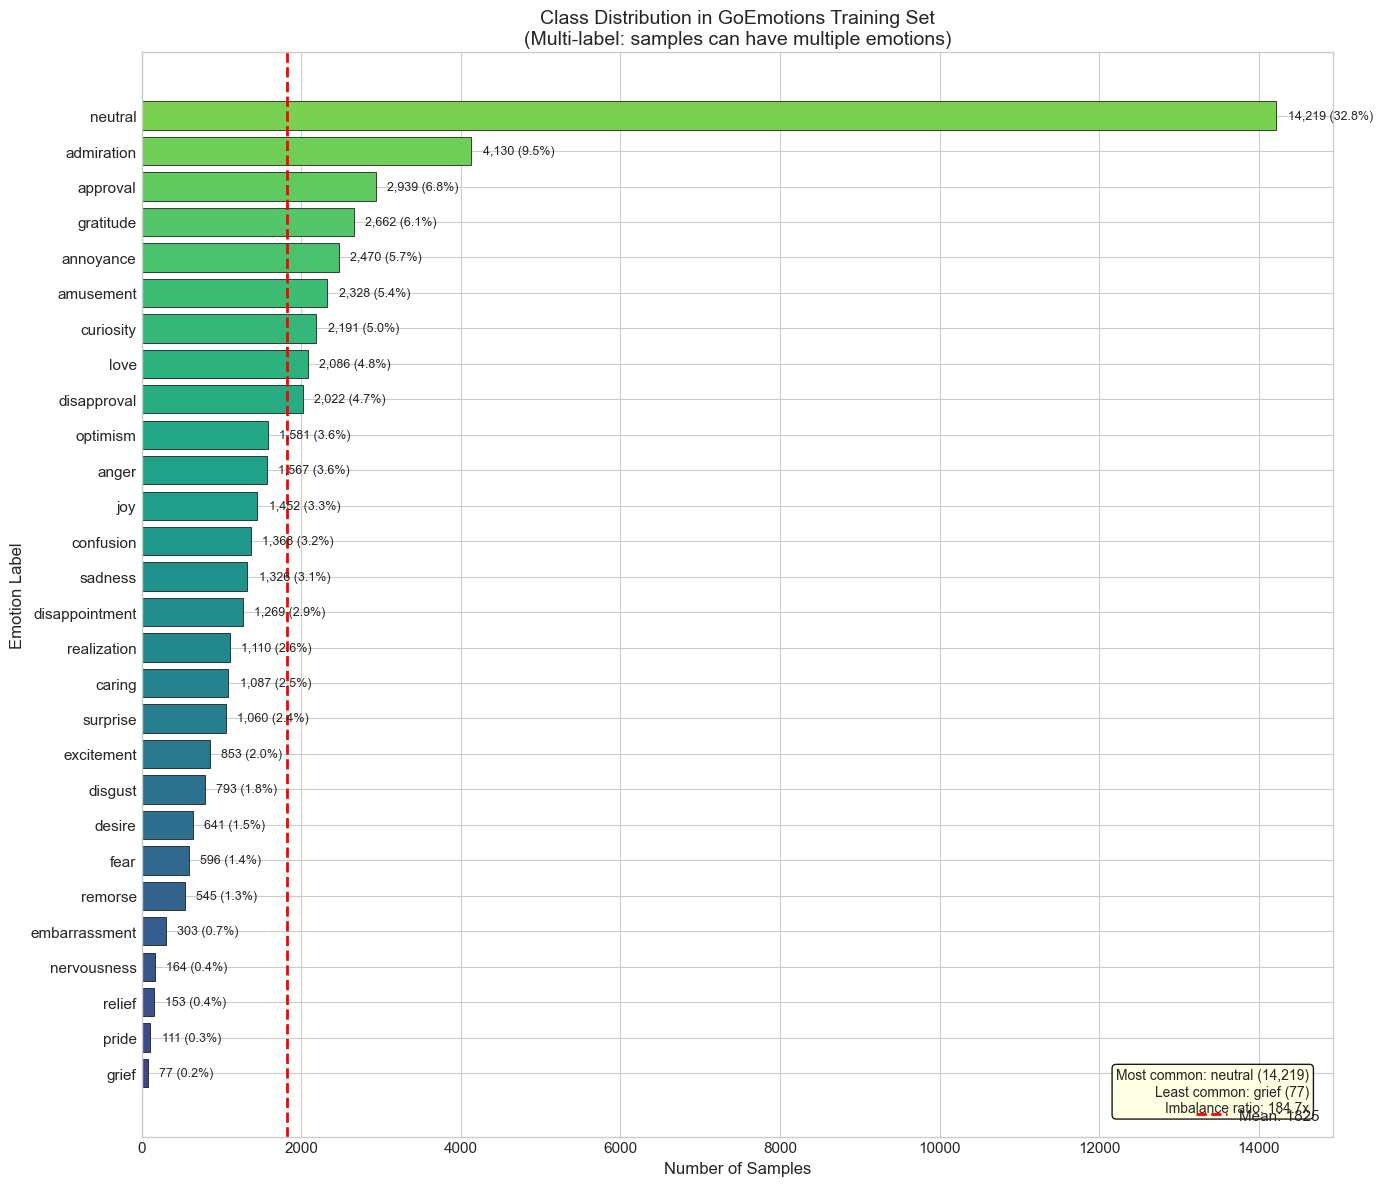


Class Distribution Statistics:
Most common:   neutral         (14,219 samples, 32.8%)
Least common:  grief           (77 samples, 0.18%)
Mean count:    1825 samples
Median count:  1298 samples
Imbalance ratio: 184.7x


In [8]:
# Calculate class counts
class_counts = train_df[EMOTION_LABELS].sum().sort_values(ascending=True)

# Create horizontal bar chart with improved styling
fig, ax = plt.subplots(figsize=(14, 12))

# Color gradient based on counts
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(class_counts)))

bars = ax.barh(class_counts.index, class_counts.values, color=colors, edgecolor='black', linewidth=0.5)

# Add count labels
max_count = class_counts.values.max()
for bar, count in zip(bars, class_counts.values):
    pct = count / len(train_df) * 100
    ax.text(count + max_count * 0.01, bar.get_y() + bar.get_height()/2, 
            f'{int(count):,} ({pct:.1f}%)', va='center', fontsize=9)

ax.set_xlabel('Number of Samples', fontsize=12)
ax.set_ylabel('Emotion Label', fontsize=12)
ax.set_title('Class Distribution in GoEmotions Training Set\n(Multi-label: samples can have multiple emotions)', fontsize=14)

# Add vertical line for mean
mean_count = class_counts.values.mean()
ax.axvline(mean_count, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_count:.0f}')
ax.legend(loc='lower right')

# Add summary statistics
stats_text = f"Most common: {class_counts.index[-1]} ({class_counts.values[-1]:,})\n"
stats_text += f"Least common: {class_counts.index[0]} ({class_counts.values[0]:,})\n"
stats_text += f"Imbalance ratio: {class_counts.values[-1] / class_counts.values[0]:.1f}x"
ax.text(0.98, 0.02, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
save_figure('eda_class_distribution.png')
plt.show()

print("\nClass Distribution Statistics:")
print(f"Most common:   {class_counts.index[-1]:15s} ({class_counts.values[-1]:,} samples, {class_counts.values[-1]/len(train_df)*100:.1f}%)")
print(f"Least common:  {class_counts.index[0]:15s} ({class_counts.values[0]:,} samples, {class_counts.values[0]/len(train_df)*100:.2f}%)")
print(f"Mean count:    {mean_count:.0f} samples")
print(f"Median count:  {np.median(class_counts.values):.0f} samples")
print(f"Imbalance ratio: {class_counts.values[-1] / class_counts.values[0]:.1f}x")

Saved: ../screenshots/eda_labels_per_sample.png


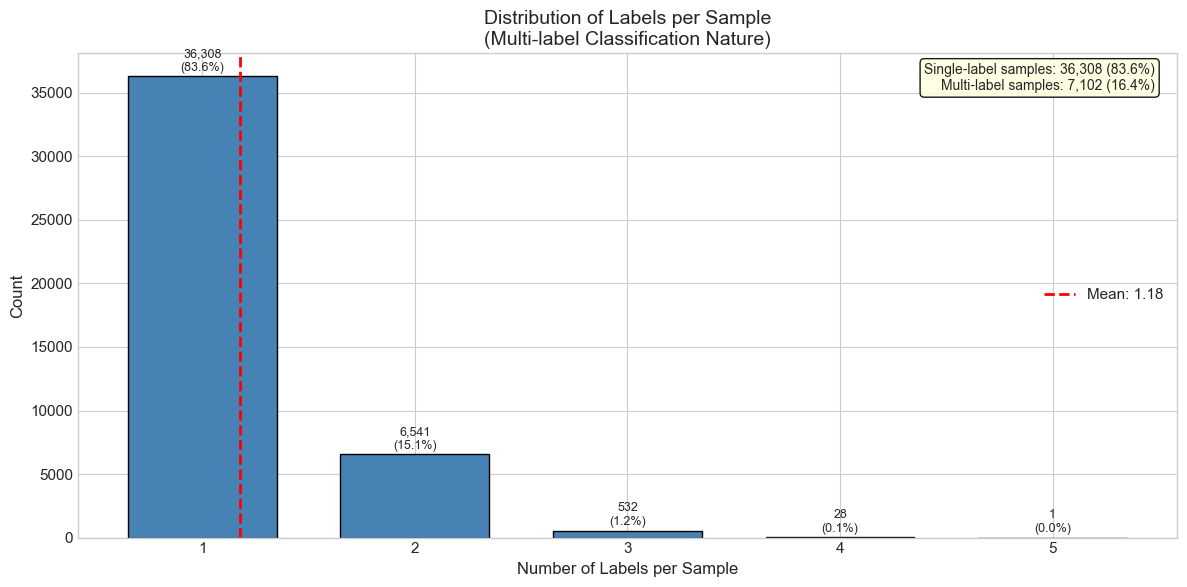


Labels per Sample Statistics:
Single label samples:   36,308 (83.6%)
Multiple label samples: 7,102 (16.4%)
Mean labels per sample: 1.18
Max labels per sample:  5


In [9]:
# Labels per sample distribution
labels_per_sample = train_df[EMOTION_LABELS].sum(axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

# Get value counts and sort by index
label_dist = labels_per_sample.value_counts().sort_index()

bars = ax.bar(label_dist.index, label_dist.values, color='steelblue', edgecolor='black', width=0.7)

# Add count labels on bars
for bar, count in zip(bars, label_dist.values):
    pct = count / len(train_df) * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200, 
            f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Number of Labels per Sample', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Labels per Sample\n(Multi-label Classification Nature)', fontsize=14)
ax.set_xticks(label_dist.index)

# Add statistics
mean_labels = labels_per_sample.mean()
ax.axvline(mean_labels, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_labels:.2f}')
ax.legend()

# Add summary
single_label = (labels_per_sample == 1).sum()
multi_label = (labels_per_sample > 1).sum()
stats_text = f"Single-label samples: {single_label:,} ({single_label/len(train_df)*100:.1f}%)\n"
stats_text += f"Multi-label samples: {multi_label:,} ({multi_label/len(train_df)*100:.1f}%)"
ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
save_figure('eda_labels_per_sample.png')
plt.show()

print("\nLabels per Sample Statistics:")
print(f"Single label samples:   {single_label:,} ({single_label/len(train_df)*100:.1f}%)")
print(f"Multiple label samples: {multi_label:,} ({multi_label/len(train_df)*100:.1f}%)")
print(f"Mean labels per sample: {mean_labels:.2f}")
print(f"Max labels per sample:  {labels_per_sample.max()}")

## 6. Text Length Analysis

Saved: ../screenshots/eda_text_length.png


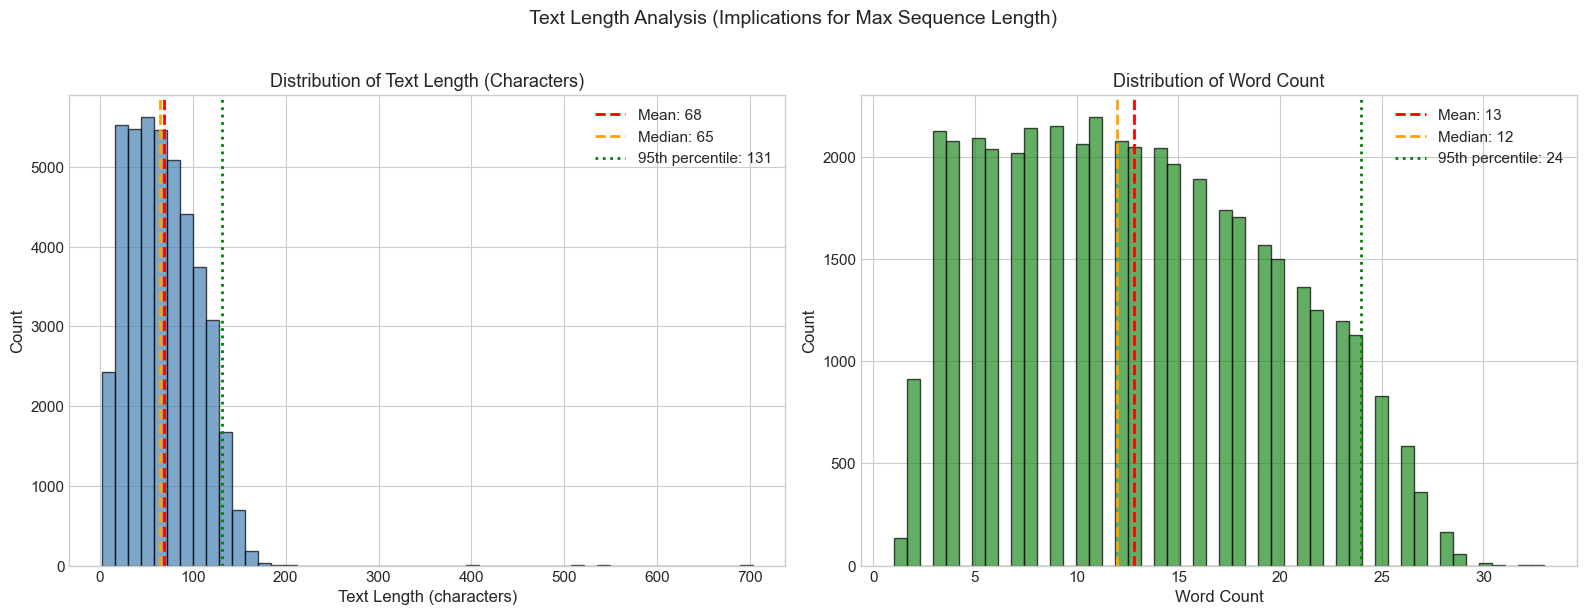


Text Length Statistics:
       text_length  word_count
count      43410.0     43410.0
mean          68.4        12.8
std           36.7         6.7
min            2.0         1.0
25%           38.0         7.0
50%           65.0        12.0
75%           96.0        18.0
max          703.0        33.0

95th percentile - Characters: 131, Words: 24

Recommended max_length for transformers: 128 (covers 100.0% of samples)


In [10]:
# Calculate text lengths
train_df['text_length'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Character length distribution
ax1 = axes[0]
ax1.hist(train_df['text_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(train_df['text_length'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {train_df["text_length"].mean():.0f}')
ax1.axvline(train_df['text_length'].median(), color='orange', linestyle='--', linewidth=2, 
            label=f'Median: {train_df["text_length"].median():.0f}')
ax1.set_xlabel('Text Length (characters)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of Text Length (Characters)', fontsize=13)
ax1.legend()

# Add percentile info
p95 = train_df['text_length'].quantile(0.95)
ax1.axvline(p95, color='green', linestyle=':', linewidth=2, label=f'95th percentile: {p95:.0f}')
ax1.legend()

# Word count distribution
ax2 = axes[1]
ax2.hist(train_df['word_count'], bins=50, color='forestgreen', edgecolor='black', alpha=0.7)
ax2.axvline(train_df['word_count'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {train_df["word_count"].mean():.0f}')
ax2.axvline(train_df['word_count'].median(), color='orange', linestyle='--', linewidth=2, 
            label=f'Median: {train_df["word_count"].median():.0f}')
ax2.set_xlabel('Word Count', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Distribution of Word Count', fontsize=13)

p95_words = train_df['word_count'].quantile(0.95)
ax2.axvline(p95_words, color='green', linestyle=':', linewidth=2, label=f'95th percentile: {p95_words:.0f}')
ax2.legend()

plt.suptitle('Text Length Analysis (Implications for Max Sequence Length)', fontsize=14, y=1.02)
plt.tight_layout()
save_figure('eda_text_length.png')
plt.show()

print("\nText Length Statistics:")
print(train_df[['text_length', 'word_count']].describe().round(1))
print(f"\n95th percentile - Characters: {p95:.0f}, Words: {p95_words:.0f}")
print(f"\nRecommended max_length for transformers: 128 (covers {(train_df['word_count'] <= 128).mean()*100:.1f}% of samples)")

## 7. Word Clouds for Top Emotions

Saved: ../screenshots/eda_wordclouds.png


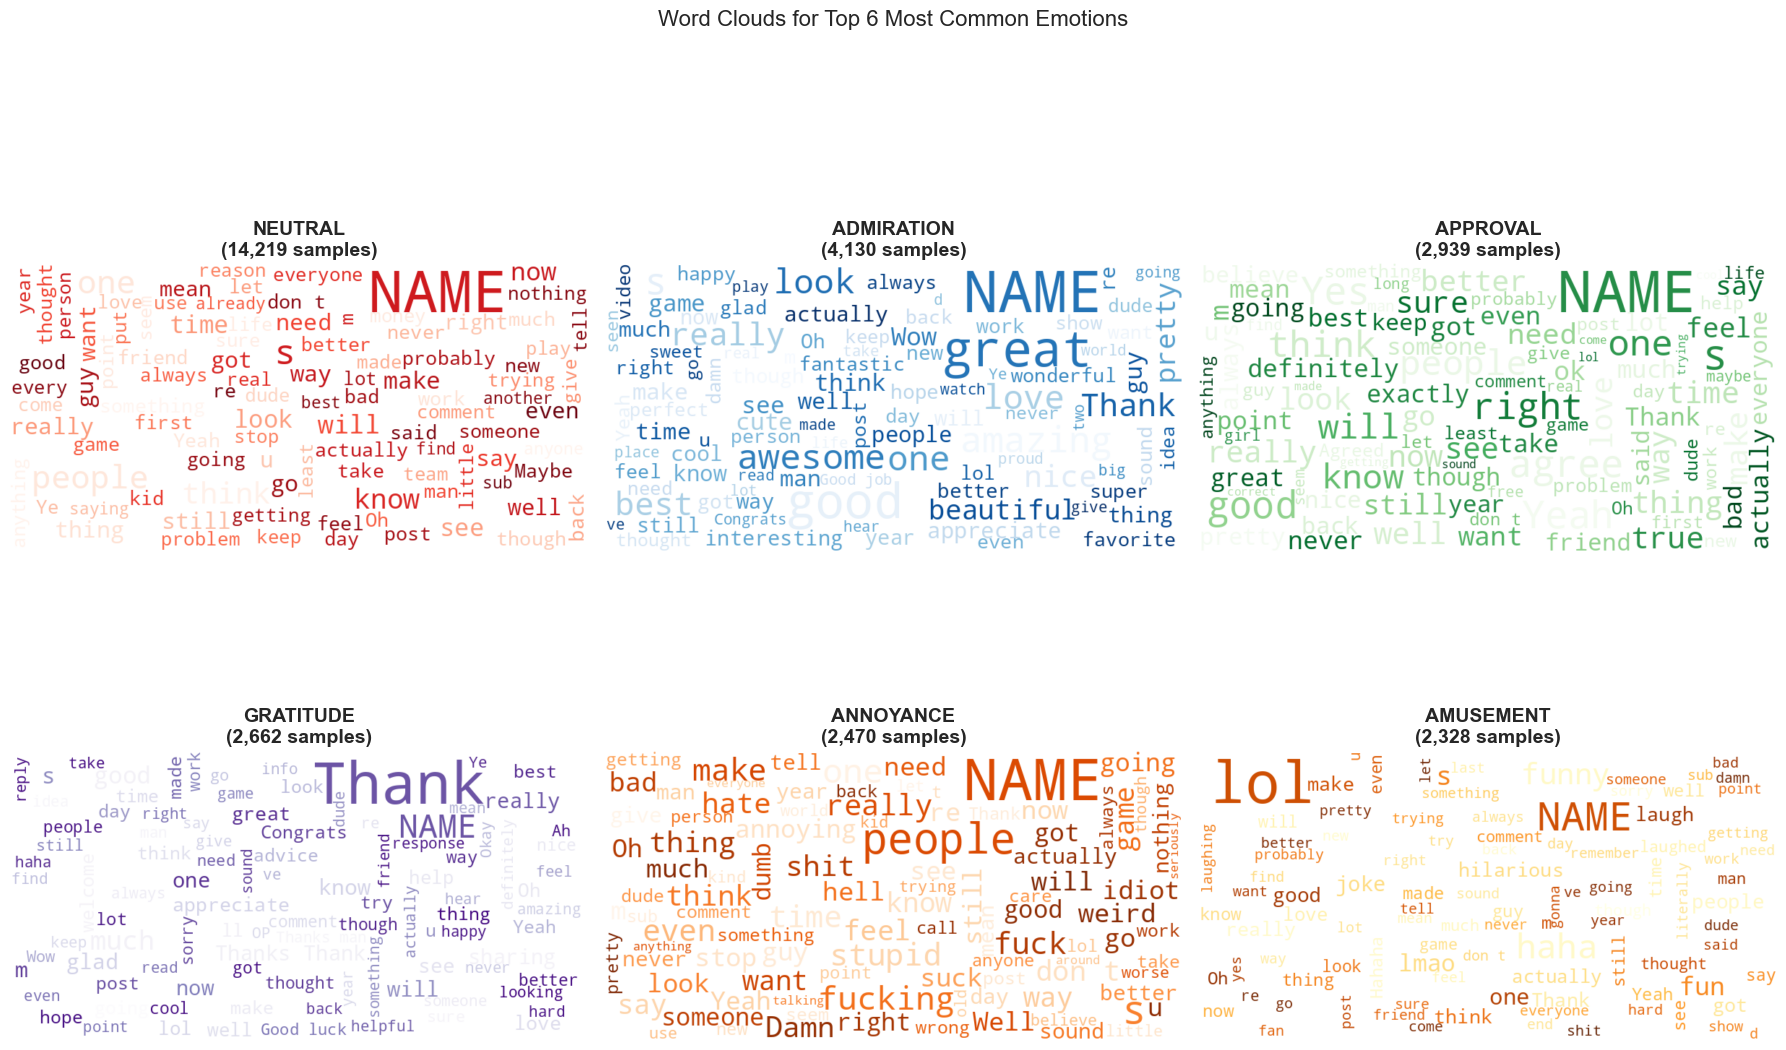


Top 6 emotions visualized:
  neutral     : 14,219 samples (32.8%)
  admiration  : 4,130 samples (9.5%)
  approval    : 2,939 samples (6.8%)
  gratitude   : 2,662 samples (6.1%)
  annoyance   : 2,470 samples (5.7%)
  amusement   : 2,328 samples (5.4%)


In [11]:
# Select top 6 emotions for word clouds (most common)
top_emotions = class_counts.tail(6).index.tolist()[::-1]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Define colormaps for variety
colormaps = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges', 'YlOrBr']

for idx, emotion in enumerate(top_emotions):
    # Get texts for this emotion
    emotion_texts = train_df[train_df[emotion] == 1]['text']
    text = ' '.join(emotion_texts.values)
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        max_words=100,
        colormap=colormaps[idx],
        random_state=SEED,
        min_font_size=10,
        max_font_size=80
    ).generate(text)
    
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{emotion.upper()}\n({len(emotion_texts):,} samples)', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Word Clouds for Top 6 Most Common Emotions', fontsize=16, y=1.02)
plt.tight_layout()
save_figure('eda_wordclouds.png')
plt.show()

print("\nTop 6 emotions visualized:")
for emotion in top_emotions:
    count = class_counts[emotion]
    print(f"  {emotion:12s}: {count:,} samples ({count/len(train_df)*100:.1f}%)")

## 8. Label Co-occurrence Matrix

Saved: ../screenshots/eda_cooccurrence.png


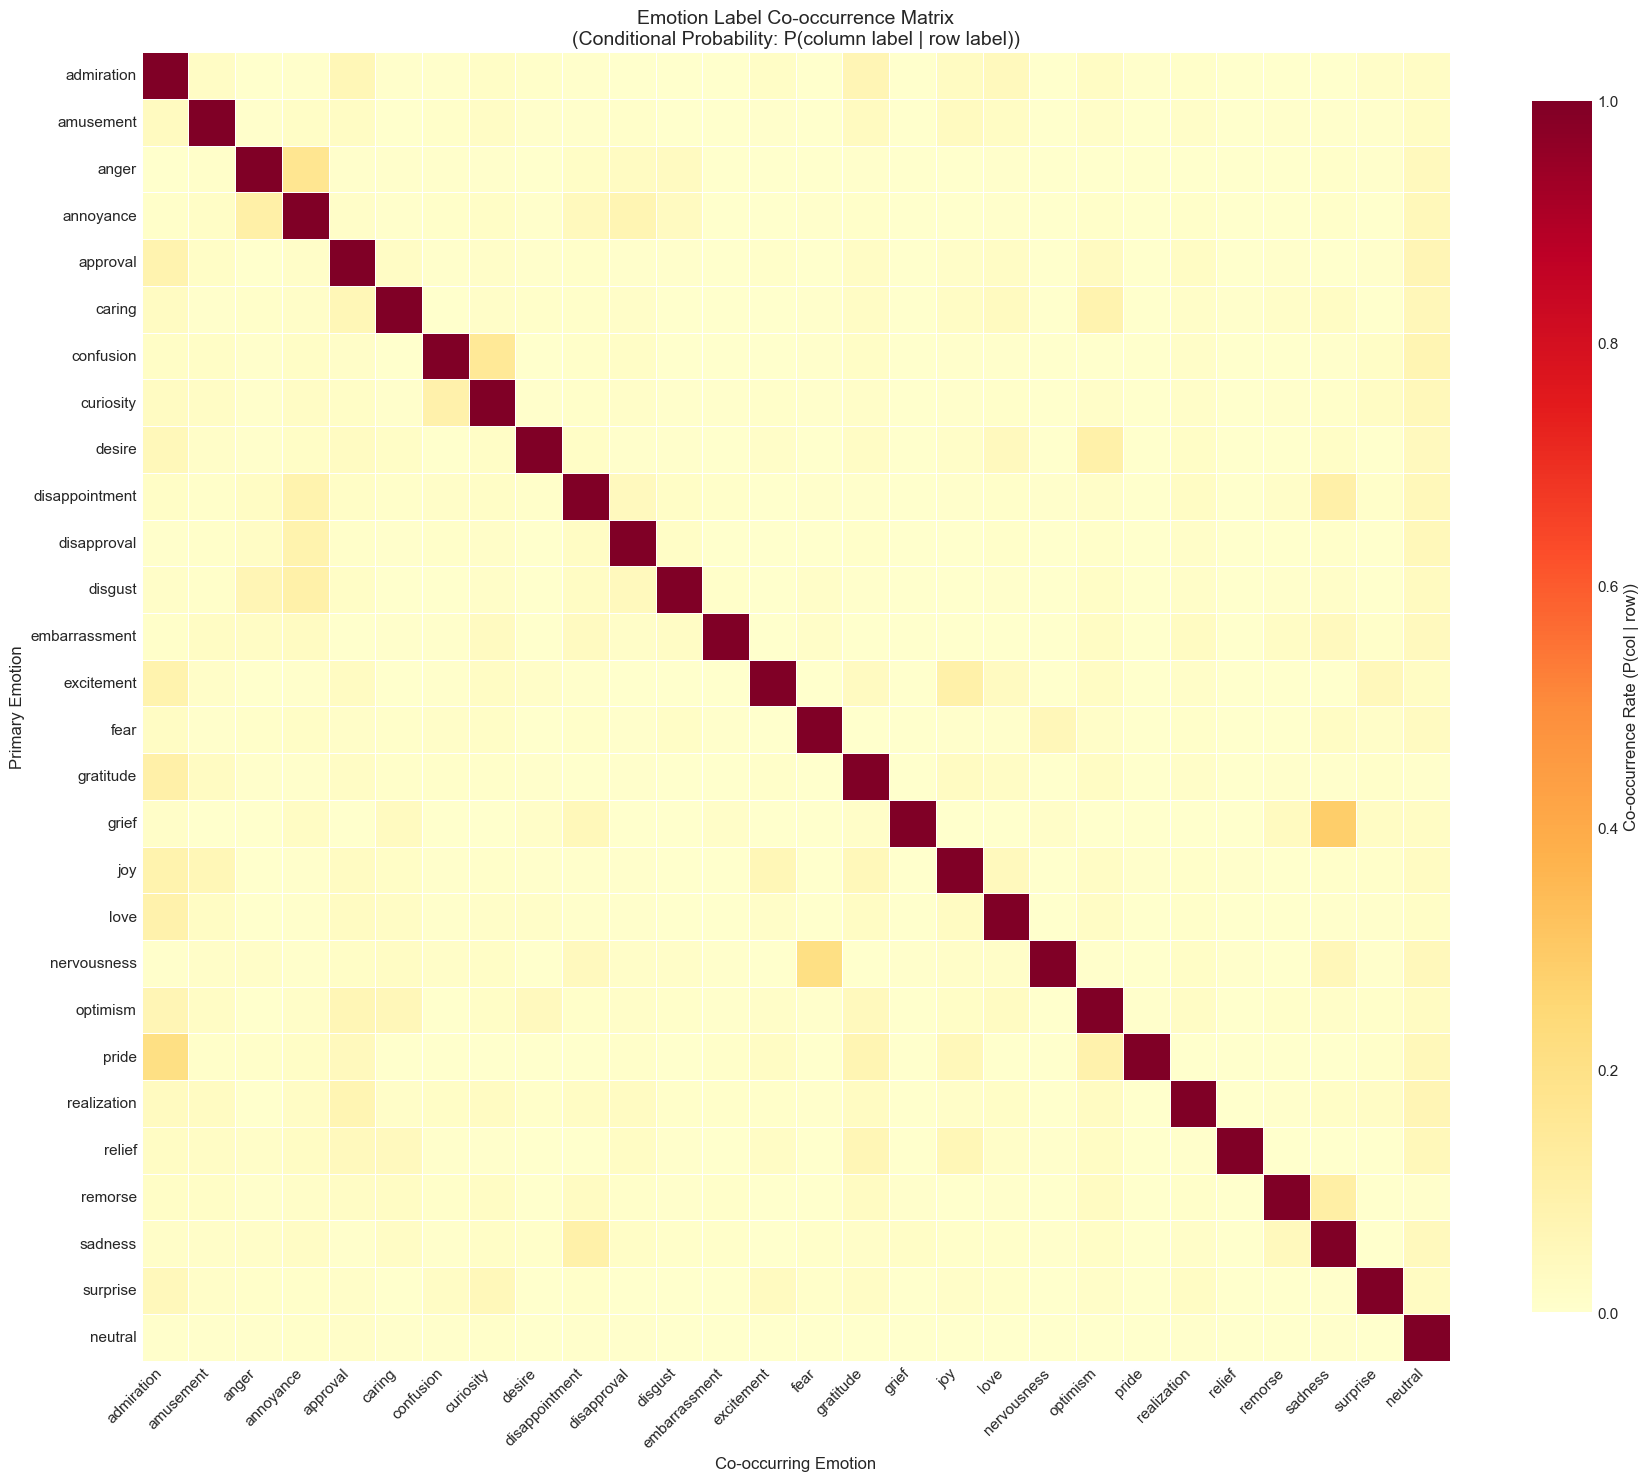


Co-occurrence matrix computed successfully!
Matrix shape: (28, 28)


In [12]:
# Calculate co-occurrence matrix
label_matrix = train_df[EMOTION_LABELS].values
cooccurrence = np.dot(label_matrix.T, label_matrix)

# Normalize by diagonal (self-occurrence) to get conditional probability
diag = np.diag(cooccurrence)
# Avoid division by zero
diag_safe = np.where(diag == 0, 1, diag)
cooccurrence_normalized = cooccurrence / diag_safe[:, np.newaxis]

# Create heatmap
fig, ax = plt.subplots(figsize=(18, 16))

# Create mask for upper triangle (optional, to reduce visual clutter)
# mask = np.triu(np.ones_like(cooccurrence_normalized, dtype=bool), k=1)

sns.heatmap(
    cooccurrence_normalized,
    xticklabels=EMOTION_LABELS,
    yticklabels=EMOTION_LABELS,
    cmap='YlOrRd',
    annot=False,
    square=True,
    cbar_kws={'label': 'Co-occurrence Rate (P(col | row))', 'shrink': 0.8},
    linewidths=0.5,
    linecolor='white',
    ax=ax
)

ax.set_title('Emotion Label Co-occurrence Matrix\n(Conditional Probability: P(column label | row label))', fontsize=14)
ax.set_xlabel('Co-occurring Emotion', fontsize=12)
ax.set_ylabel('Primary Emotion', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
save_figure('eda_cooccurrence.png')
plt.show()

print("\nCo-occurrence matrix computed successfully!")
print(f"Matrix shape: {cooccurrence.shape}")

## 9. Top Co-occurring Pairs Analysis

In [13]:
# Find top co-occurring pairs
cooc_df = pd.DataFrame(cooccurrence, index=EMOTION_LABELS, columns=EMOTION_LABELS)

# Get pairs (excluding self-occurrence)
pairs = []
for i, label1 in enumerate(EMOTION_LABELS):
    for j, label2 in enumerate(EMOTION_LABELS):
        if i < j:  # Only upper triangle to avoid duplicates
            pairs.append({
                'Emotion 1': label1,
                'Emotion 2': label2,
                'Co-occurrences': int(cooccurrence[i, j]),
                'Rate (%)': cooccurrence[i, j] / max(diag[i], diag[j]) * 100
            })

pairs_df = pd.DataFrame(pairs).sort_values('Co-occurrences', ascending=False)

print("=" * 60)
print("TOP 15 CO-OCCURRING EMOTION PAIRS")
print("=" * 60)
print(pairs_df.head(15).to_string(index=False))

TOP 15 CO-OCCURRING EMOTION PAIRS
     Emotion 1      Emotion 2  Co-occurrences  Rate (%)
    admiration      gratitude             279  6.755448
         anger      annoyance             269 10.890688
    admiration       approval             246  5.956416
     confusion      curiosity             212  9.675947
      approval        neutral             202  1.420634
    admiration           love             192  4.648910
     annoyance    disapproval             178  7.206478
disappointment        sadness             133 10.030166
     annoyance        neutral             132  0.928335
    admiration            joy             126  3.050847
     curiosity        neutral             118  0.829876
     annoyance disappointment             110  4.453441
   disapproval        neutral             109  0.766580
    admiration       optimism             106  2.566586
      approval       optimism             100  3.402518


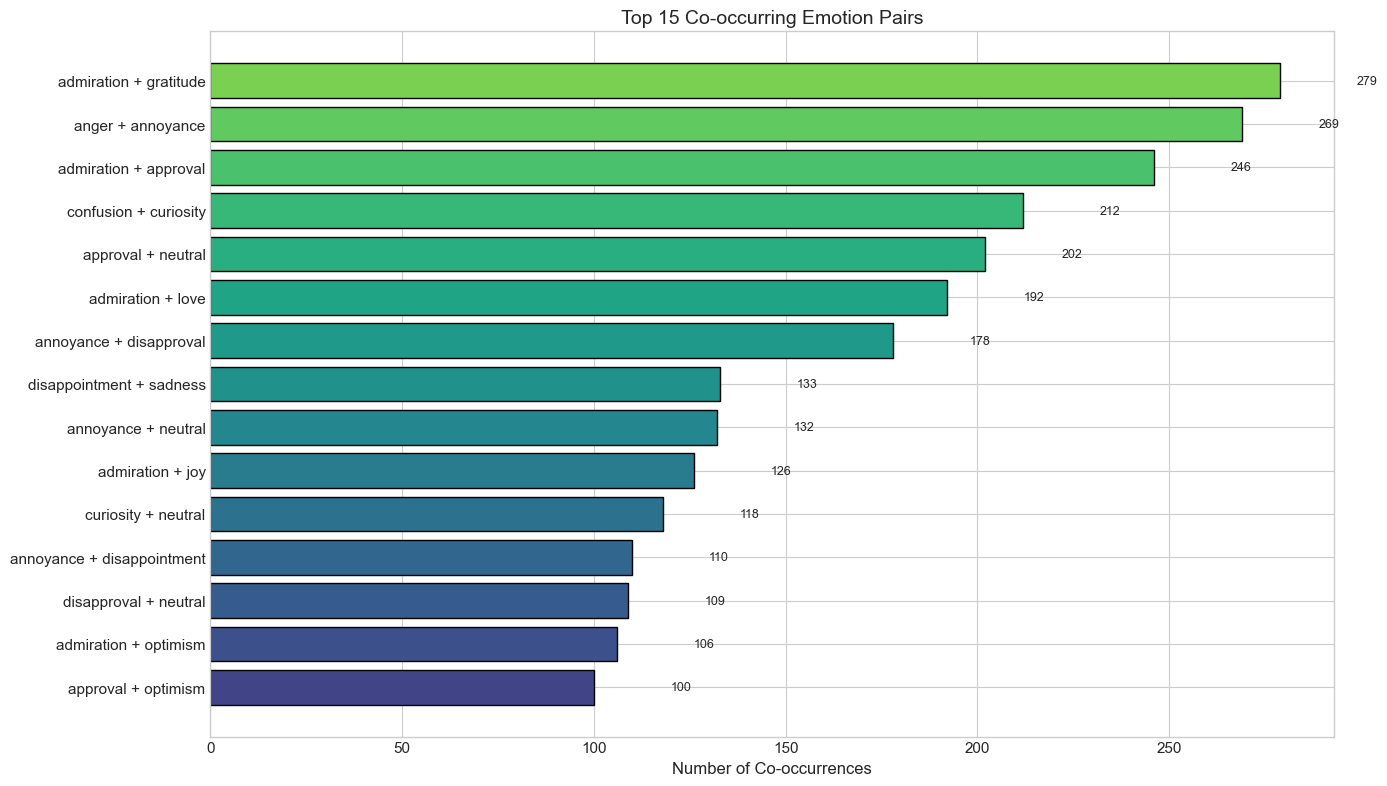


Insight: Similar emotions tend to co-occur (e.g., approval+admiration, annoyance+disapproval)


In [14]:
# Visualize top co-occurring pairs
fig, ax = plt.subplots(figsize=(14, 8))

top_pairs = pairs_df.head(15)
pair_labels = [f"{row['Emotion 1']} + {row['Emotion 2']}" for _, row in top_pairs.iterrows()]

bars = ax.barh(range(len(top_pairs)), top_pairs['Co-occurrences'], 
               color=plt.cm.viridis(np.linspace(0.8, 0.2, len(top_pairs))), 
               edgecolor='black')

ax.set_yticks(range(len(top_pairs)))
ax.set_yticklabels(pair_labels)
ax.set_xlabel('Number of Co-occurrences', fontsize=12)
ax.set_title('Top 15 Co-occurring Emotion Pairs', fontsize=14)

# Add count labels
for i, (bar, count) in enumerate(zip(bars, top_pairs['Co-occurrences'])):
    ax.text(count + 20, bar.get_y() + bar.get_height()/2, 
            f'{count:,}', va='center', fontsize=9)

ax.invert_yaxis()  # Highest at top
plt.tight_layout()
plt.show()

print("\nInsight: Similar emotions tend to co-occur (e.g., approval+admiration, annoyance+disapproval)")

## 10. Data Quality Check

In [15]:
# Comprehensive data quality check
print("=" * 60)
print("DATA QUALITY CHECK")
print("=" * 60)

# 1. Missing Values
print("\n1. Missing Values:")
missing_text = train_df['text'].isnull().sum()
missing_labels = train_df['labels'].isnull().sum()
print(f"   Text column:   {missing_text} missing ({missing_text/len(train_df)*100:.2f}%)")
print(f"   Labels column: {missing_labels} missing ({missing_labels/len(train_df)*100:.2f}%)")

# 2. Empty texts
print("\n2. Empty/Whitespace Texts:")
empty_texts = (train_df['text'].str.strip() == '').sum()
print(f"   Empty texts: {empty_texts}")

# 3. Duplicates
print("\n3. Duplicate Texts:")
duplicates = train_df['text'].duplicated().sum()
print(f"   Duplicate texts: {duplicates} ({duplicates/len(train_df)*100:.2f}%)")

# 4. Samples with no labels
print("\n4. Samples with No Labels:")
no_labels = (train_df[EMOTION_LABELS].sum(axis=1) == 0).sum()
print(f"   Samples with no labels: {no_labels}")

# 5. Text quality
print("\n5. Text Quality:")
very_short = (train_df['text_length'] < 10).sum()
very_long = (train_df['text_length'] > 500).sum()
print(f"   Very short texts (<10 chars): {very_short} ({very_short/len(train_df)*100:.2f}%)")
print(f"   Very long texts (>500 chars): {very_long} ({very_long/len(train_df)*100:.2f}%)")

# 6. Special characters
print("\n6. Text Characteristics:")
has_url = train_df['text'].str.contains(r'https?://', regex=True).sum()
has_mention = train_df['text'].str.contains(r'@\w+', regex=True).sum()
print(f"   Texts with URLs: {has_url} ({has_url/len(train_df)*100:.2f}%)")
print(f"   Texts with @mentions: {has_mention} ({has_mention/len(train_df)*100:.2f}%)")

# Overall quality score
print("\n" + "=" * 60)
quality_issues = missing_text + missing_labels + empty_texts + no_labels
quality_score = (1 - quality_issues / len(train_df)) * 100
print(f"OVERALL DATA QUALITY SCORE: {quality_score:.2f}%")
print("=" * 60)

DATA QUALITY CHECK

1. Missing Values:
   Text column:   0 missing (0.00%)
   Labels column: 0 missing (0.00%)

2. Empty/Whitespace Texts:
   Empty texts: 0

3. Duplicate Texts:
   Duplicate texts: 183 (0.42%)

4. Samples with No Labels:
   Samples with no labels: 0

5. Text Quality:
   Very short texts (<10 chars): 322 (0.74%)
   Very long texts (>500 chars): 3 (0.01%)

6. Text Characteristics:
   Texts with URLs: 0 (0.00%)
   Texts with @mentions: 7 (0.02%)

OVERALL DATA QUALITY SCORE: 100.00%


## 11. Sample Texts by Emotion

In [16]:
# Sample examples from different emotions
print("=" * 80)
print("SAMPLE TEXTS BY EMOTION")
print("=" * 80)

sample_emotions = ['joy', 'anger', 'sadness', 'fear', 'surprise', 'gratitude', 'confusion', 'admiration']

for emotion in sample_emotions:
    emotion_df = train_df[train_df[emotion] == 1]
    if len(emotion_df) > 0:
        samples = emotion_df['text'].sample(min(2, len(emotion_df)), random_state=SEED)
        print(f"\n{emotion.upper()} ({len(emotion_df):,} total samples):")
        for i, text in enumerate(samples, 1):
            # Truncate long texts
            display_text = text[:120] + '...' if len(text) > 120 else text
            print(f"  {i}. \"{display_text}\"")

SAMPLE TEXTS BY EMOTION

JOY (1,452 total samples):
  1. "ive had 300ug tabs before, took 2 had full on ego death was naked with my friends jumping on moving cars "
  2. "This is the sweetest."

ANGER (1,567 total samples):
  1. "They didn't actually run any tests to confirm it was even bone, let alone human."
  2. "Yep, hell of a listener"

SADNESS (1,326 total samples):
  1. "You sound upset."
  2. "I'm so sorry. Read about you getting kicked out at home. That must be devastating"

FEAR (596 total samples):
  1. "This is scary."
  2. "That ice is dangerously thin for such a hot take."

SURPRISE (1,060 total samples):
  1. "Wow starters before 6 min mark?? Insane"
  2. ">This weird exploding ice [NAME] I haven't seen before? Wow. I... that's some ick right there."

GRATITUDE (2,662 total samples):
  1. "Not gonna lie. Sucked out a few, but am really trying to analyze my play afterwards. Thanks!"
  2. "ok thanks I'll give it a read and try to fact check"

CONFUSION (1,368 total samples

## 12. EDA Summary

In [17]:
print("=" * 70)
print("EXPLORATORY DATA ANALYSIS SUMMARY")
print("=" * 70)

print("""
1. DATASET SIZE
   - Training:   {train:,} samples
   - Validation: {val:,} samples  
   - Test:       {test:,} samples
   - Total:      {total:,} samples

2. MULTI-LABEL NATURE
   - Average labels per sample: {avg_labels:.2f}
   - Single-label samples: {single:.1f}%
   - Multi-label samples: {multi:.1f}%
   - Max labels per sample: {max_labels}

3. CLASS IMBALANCE
   - Most common:  {most_common} ({most_count:,} samples)
   - Least common: {least_common} ({least_count:,} samples)
   - Imbalance ratio: {imbalance:.1f}x

4. TEXT CHARACTERISTICS
   - Average length: {avg_len:.0f} characters / {avg_words:.0f} words
   - 95th percentile: {p95_chars:.0f} characters
   - Recommended max_length: 128 tokens

5. DATA QUALITY
   - Missing values: 0
   - Duplicates: {duplicates} ({dup_pct:.2f}%)
   - Quality score: {quality:.2f}%

6. MODELING IMPLICATIONS
   - Use weighted loss or oversampling for class imbalance
   - Threshold optimization important for multi-label
   - Consider emotion hierarchies (similar emotions co-occur)
   - Max sequence length of 128 covers most samples
""".format(
    train=len(train_df),
    val=len(val_df),
    test=len(test_df),
    total=len(train_df)+len(val_df)+len(test_df),
    avg_labels=labels_per_sample.mean(),
    single=(labels_per_sample == 1).mean()*100,
    multi=(labels_per_sample > 1).mean()*100,
    max_labels=labels_per_sample.max(),
    most_common=class_counts.index[-1],
    most_count=class_counts.values[-1],
    least_common=class_counts.index[0],
    least_count=class_counts.values[0],
    imbalance=class_counts.values[-1]/class_counts.values[0],
    avg_len=train_df['text_length'].mean(),
    avg_words=train_df['word_count'].mean(),
    p95_chars=train_df['text_length'].quantile(0.95),
    duplicates=duplicates,
    dup_pct=duplicates/len(train_df)*100,
    quality=quality_score
))

EXPLORATORY DATA ANALYSIS SUMMARY

1. DATASET SIZE
   - Training:   43,410 samples
   - Validation: 5,426 samples  
   - Test:       5,427 samples
   - Total:      54,263 samples

2. MULTI-LABEL NATURE
   - Average labels per sample: 1.18
   - Single-label samples: 83.6%
   - Multi-label samples: 16.4%
   - Max labels per sample: 5

3. CLASS IMBALANCE
   - Most common:  neutral (14,219 samples)
   - Least common: grief (77 samples)
   - Imbalance ratio: 184.7x

4. TEXT CHARACTERISTICS
   - Average length: 68 characters / 13 words
   - 95th percentile: 131 characters
   - Recommended max_length: 128 tokens

5. DATA QUALITY
   - Missing values: 0
   - Duplicates: 183 (0.42%)
   - Quality score: 100.00%

6. MODELING IMPLICATIONS
   - Use weighted loss or oversampling for class imbalance
   - Threshold optimization important for multi-label
   - Consider emotion hierarchies (similar emotions co-occur)
   - Max sequence length of 128 covers most samples



---

# Part 3: Data Preprocessing

## 13. Preprocessing Pipeline Setup

In [18]:
# Prepare data for training
print("=" * 50)
print("DATA PREPROCESSING")
print("=" * 50)

# Extract texts and labels
train_texts = list(dataset['train']['text'])
val_texts = list(dataset['validation']['text'])
test_texts = list(dataset['test']['text'])

# Create label matrices
train_labels = create_label_matrix(dataset['train'])
val_labels = create_label_matrix(dataset['validation'])
test_labels = create_label_matrix(dataset['test'])

print(f"\nTrain texts: {len(train_texts)}, Labels shape: {train_labels.shape}")
print(f"Val texts:   {len(val_texts)}, Labels shape: {val_labels.shape}")
print(f"Test texts:  {len(test_texts)}, Labels shape: {test_labels.shape}")

print(f"\nLabel matrix dtype: {train_labels.dtype}")
print(f"Label values: {np.unique(train_labels)}")

DATA PREPROCESSING



Train texts: 43410, Labels shape: (43410, 28)
Val texts:   5426, Labels shape: (5426, 28)
Test texts:  5427, Labels shape: (5427, 28)

Label matrix dtype: float32
Label values: [0. 1.]


## 14. TF-IDF Vectorization Analysis

In [19]:
# Demonstrate TF-IDF vectorization
config = MODEL_CONFIGS['tfidf']

print("TF-IDF Vectorizer Configuration:")
print(f"  max_features: {config['max_features']}")
print(f"  ngram_range:  {config['ngram_range']}")

# Create vectorizer for analysis
tfidf_analyzer = TfidfVectorizer(
    max_features=config['max_features'],
    ngram_range=config['ngram_range'],
    stop_words='english',
    min_df=2,
    max_df=0.95
)

# Fit on training data
X_train_tfidf = tfidf_analyzer.fit_transform(train_texts)

print(f"\nTF-IDF Matrix Shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_analyzer.vocabulary_)}")
print(f"Sparsity: {(1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100:.2f}%")

TF-IDF Vectorizer Configuration:
  max_features: 10000
  ngram_range:  (1, 2)



TF-IDF Matrix Shape: (43410, 10000)
Vocabulary size: 10000
Sparsity: 99.94%


In [20]:
# Show top features (words) by IDF score
feature_names = np.array(tfidf_analyzer.get_feature_names_out())
idf_scores = tfidf_analyzer.idf_

# Sort by IDF (lower = more common, higher = more rare/distinctive)
sorted_indices = np.argsort(idf_scores)

print("\nMost Common Words (lowest IDF):")
for i in sorted_indices[:10]:
    print(f"  {feature_names[i]:20s} IDF: {idf_scores[i]:.3f}")

print("\nMost Distinctive Words (highest IDF):")
for i in sorted_indices[-10:]:
    print(f"  {feature_names[i]:20s} IDF: {idf_scores[i]:.3f}")


Most Common Words (lowest IDF):
  just                 IDF: 3.563
  like                 IDF: 3.628
  don                  IDF: 4.059
  love                 IDF: 4.162
  people               IDF: 4.238
  good                 IDF: 4.256
  really               IDF: 4.424
  know                 IDF: 4.436
  think                IDF: 4.437
  thanks               IDF: 4.528

Most Distinctive Words (highest IDF):
  stuck inside         IDF: 10.580
  nope nope            IDF: 10.580
  nyxl                 IDF: 10.580
  oh oh                IDF: 10.580
  dmc                  IDF: 10.580
  dun dun              IDF: 10.580
  woah woah            IDF: 10.580
  serenity             IDF: 10.580
  blah                 IDF: 10.580
  kabhi                IDF: 10.580


## 15. Class Weights Calculation

In [21]:
# Calculate class weights for handling imbalance
class_weights = compute_class_weights(dataset['train'])

# Create DataFrame for display
weight_df = pd.DataFrame({
    'Emotion': EMOTION_LABELS,
    'Count': train_df[EMOTION_LABELS].sum().values,
    'Weight': class_weights
}).sort_values('Weight', ascending=False)

print("=" * 50)
print("CLASS WEIGHTS FOR IMBALANCE HANDLING")
print("=" * 50)
print("\nInverse frequency weighting (normalized to mean=1):")
print(weight_df.to_string(index=False))

print(f"\nWeight range: [{class_weights.min():.3f}, {class_weights.max():.3f}]")
print(f"Weight ratio: {class_weights.max() / class_weights.min():.1f}x")

CLASS WEIGHTS FOR IMBALANCE HANDLING

Inverse frequency weighting (normalized to mean=1):
       Emotion  Count   Weight
         grief     77 6.525442
         pride    111 4.526658
        relief    153 3.284046
   nervousness    164 3.063775
 embarrassment    303 1.658281
       remorse    545 0.921943
          fear    596 0.843052
        desire    641 0.783867
       disgust    793 0.633618
    excitement    853 0.589049
      surprise   1060 0.474018
        caring   1087 0.462244
   realization   1110 0.452666
disappointment   1269 0.395949
       sadness   1326 0.378928
     confusion   1368 0.367295
           joy   1452 0.346046
         anger   1567 0.320650
      optimism   1581 0.317811
   disapproval   2022 0.248496
          love   2086 0.240872
     curiosity   2191 0.229329
     amusement   2328 0.215833
     annoyance   2470 0.203425
     gratitude   2662 0.188752
      approval   2939 0.170963
    admiration   4130 0.121661
       neutral  14219 0.035337

Weight ran

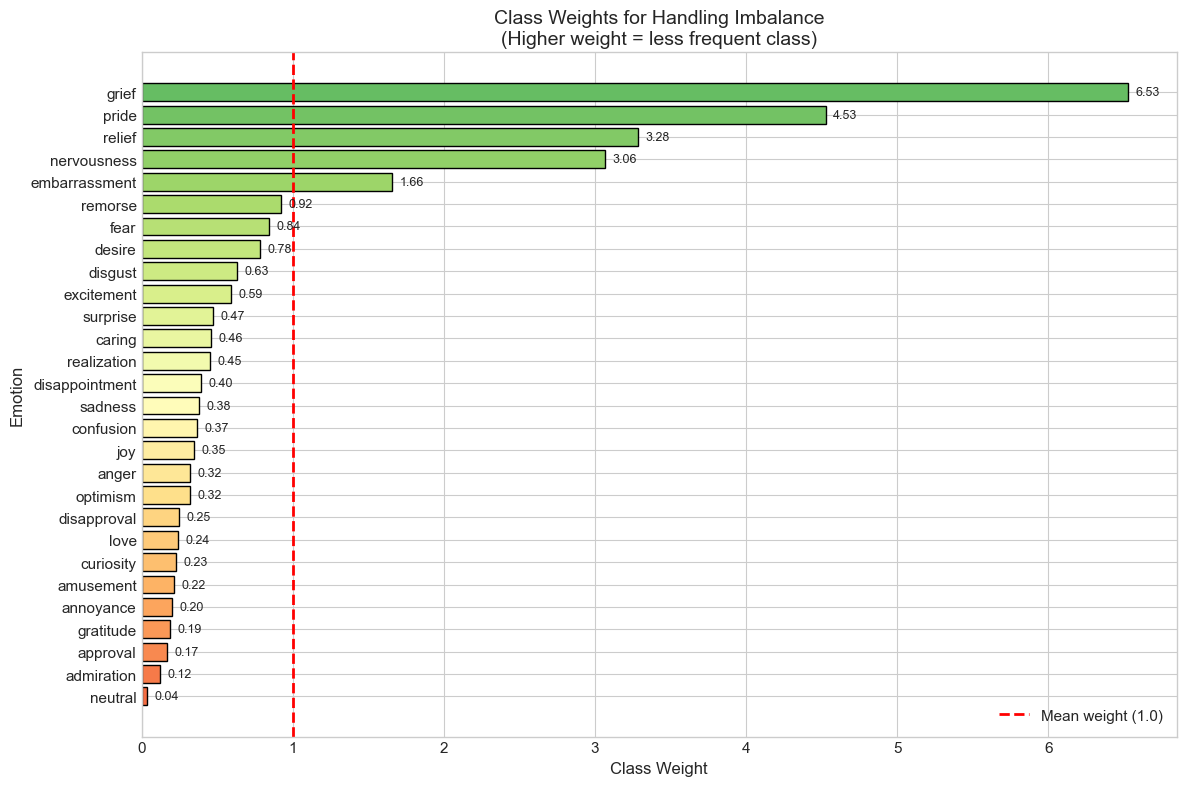

In [22]:
# Visualize class weights
fig, ax = plt.subplots(figsize=(12, 8))

weight_df_sorted = weight_df.sort_values('Weight')
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(weight_df_sorted)))

bars = ax.barh(weight_df_sorted['Emotion'], weight_df_sorted['Weight'], color=colors, edgecolor='black')

ax.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Mean weight (1.0)')
ax.set_xlabel('Class Weight', fontsize=12)
ax.set_ylabel('Emotion', fontsize=12)
ax.set_title('Class Weights for Handling Imbalance\n(Higher weight = less frequent class)', fontsize=14)
ax.legend()

# Add weight labels
for bar, weight in zip(bars, weight_df_sorted['Weight']):
    ax.text(weight + 0.05, bar.get_y() + bar.get_height()/2, 
            f'{weight:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

---

# Part 4: Model Training

## 16. Training Setup

In [23]:
import joblib
from sklearn.metrics import f1_score, hamming_loss

# Check device availability
print("=" * 50)
print("TRAINING ENVIRONMENT")
print("=" * 50)

print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print(f"MPS available: {torch.backends.mps.is_available()}")

# Dictionary to store all model metrics
all_model_metrics = {}

# Helper functions
def optimize_threshold(probs, labels, thresholds=None):
    """Find optimal classification threshold."""
    if thresholds is None:
        thresholds = np.arange(0.1, 0.6, 0.05)
    
    best_threshold = DEFAULT_THRESHOLD
    best_f1 = 0.0
    results = []
    
    for threshold in thresholds:
        preds = (probs >= threshold).astype(int)
        f1 = f1_score(labels, preds, average='macro', zero_division=0)
        results.append({'threshold': threshold, 'f1': f1})
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold, best_f1, results

def calculate_metrics(y_true, y_pred, y_prob=None):
    """Calculate evaluation metrics for multi-label classification."""
    metrics = {
        'micro_f1': f1_score(y_true, y_pred, average='micro', zero_division=0),
        'macro_f1': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'weighted_f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'hamming_loss': hamming_loss(y_true, y_pred),
        'samples_f1': f1_score(y_true, y_pred, average='samples', zero_division=0),
    }
    
    # Per-class F1 scores
    per_class_f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    metrics['per_class_f1'] = {
        EMOTION_LABELS[i]: float(per_class_f1[i]) for i in range(NUM_LABELS)
    }
    
    return metrics

print("\nTraining functions defined.")

TRAINING ENVIRONMENT

PyTorch version: 2.2.2
CUDA available: False
MPS available: True

Training functions defined.


## 17. TF-IDF + Logistic Regression Baseline

In [24]:
# Check if model already exists
tfidf_model_path = MODELS_DIR / 'tfidf_baseline'
tfidf_metadata_path = tfidf_model_path / 'metadata.json'

if tfidf_metadata_path.exists():
    print("Loading existing TF-IDF model...")
    with open(tfidf_metadata_path) as f:
        tfidf_metadata = json.load(f)
    
    vectorizer = joblib.load(tfidf_model_path / 'vectorizer.joblib')
    classifier = joblib.load(tfidf_model_path / 'classifier.joblib')
    
    print(f"Model loaded from: {tfidf_model_path}")
    print(f"Trained at: {tfidf_metadata['trained_at']}")
    
    TRAIN_TFIDF = False
else:
    print("No existing TF-IDF model found. Will train from scratch.")
    TRAIN_TFIDF = True

Loading existing TF-IDF model...
Model loaded from: ../models/tfidf_baseline
Trained at: 2026-02-02T22:24:42.584446


In [25]:
if TRAIN_TFIDF:
    print("\n" + "=" * 60)
    print("TRAINING TF-IDF + LOGISTIC REGRESSION BASELINE")
    print("=" * 60)
    
    config = MODEL_CONFIGS['tfidf']
    start_time = time.time()
    
    # Initialize TF-IDF vectorizer
    print(f"\nInitializing TF-IDF vectorizer...")
    print(f"  max_features: {config['max_features']}")
    print(f"  ngram_range: {config['ngram_range']}")
    
    vectorizer = TfidfVectorizer(
        max_features=config['max_features'],
        ngram_range=tuple(config['ngram_range']) if isinstance(config['ngram_range'], list) else config['ngram_range'],
        stop_words='english',
        min_df=2,
        max_df=0.95
    )
    
    # Fit and transform
    print("Fitting TF-IDF on training data...")
    X_train = vectorizer.fit_transform(train_texts)
    X_val = vectorizer.transform(val_texts)
    print(f"  Feature matrix shape: {X_train.shape}")
    
    # Train classifier
    print("\nTraining OneVsRestClassifier with LogisticRegression...")
    classifier = OneVsRestClassifier(
        LogisticRegression(
            C=1.0,
            max_iter=1000,
            class_weight='balanced',
            random_state=SEED,
            n_jobs=-1
        ),
        n_jobs=-1
    )
    
    classifier.fit(X_train, train_labels)
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.1f} seconds")
    
    # Save model
    tfidf_model_path.mkdir(parents=True, exist_ok=True)
    joblib.dump(vectorizer, tfidf_model_path / 'vectorizer.joblib')
    joblib.dump(classifier, tfidf_model_path / 'classifier.joblib')
    print(f"Model saved to: {tfidf_model_path}")
else:
    print("Using pre-trained TF-IDF model...")
    X_train = vectorizer.transform(train_texts)
    X_val = vectorizer.transform(val_texts)

Using pre-trained TF-IDF model...


In [26]:
# Get predictions and probabilities
print("\nEvaluating TF-IDF model on validation set...")
val_probs_tfidf = classifier.predict_proba(X_val)

# Optimize threshold with visualization
best_threshold_tfidf, best_f1_tfidf, threshold_results = optimize_threshold(val_probs_tfidf, val_labels)
print(f"Optimal threshold: {best_threshold_tfidf:.2f} (Macro F1: {best_f1_tfidf:.4f})")


Evaluating TF-IDF model on validation set...
Optimal threshold: 0.55 (Macro F1: 0.4003)


Saved: ../screenshots/tfidf_threshold_optimization.png


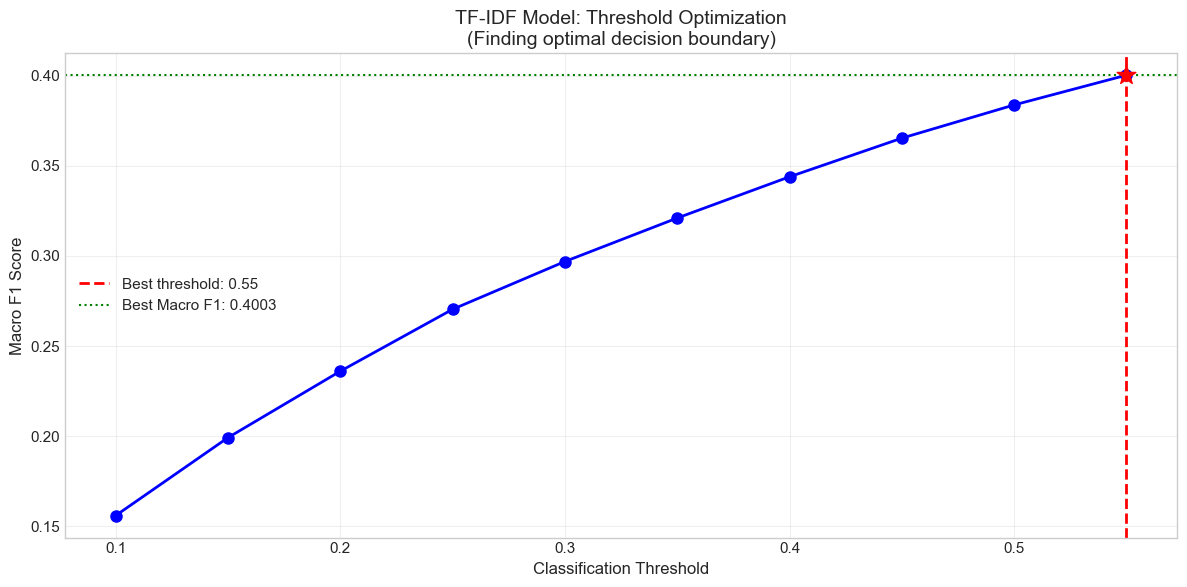

In [27]:
# Visualize threshold optimization
fig, ax = plt.subplots(figsize=(12, 6))

thresholds = [r['threshold'] for r in threshold_results]
f1_scores = [r['f1'] for r in threshold_results]

ax.plot(thresholds, f1_scores, 'b-o', linewidth=2, markersize=8)
ax.axvline(best_threshold_tfidf, color='red', linestyle='--', linewidth=2, 
           label=f'Best threshold: {best_threshold_tfidf:.2f}')
ax.axhline(best_f1_tfidf, color='green', linestyle=':', linewidth=1.5,
           label=f'Best Macro F1: {best_f1_tfidf:.4f}')

ax.set_xlabel('Classification Threshold', fontsize=12)
ax.set_ylabel('Macro F1 Score', fontsize=12)
ax.set_title('TF-IDF Model: Threshold Optimization\n(Finding optimal decision boundary)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Mark best point
ax.scatter([best_threshold_tfidf], [best_f1_tfidf], color='red', s=200, zorder=5, marker='*')

plt.tight_layout()
save_figure('tfidf_threshold_optimization.png')
plt.show()

In [28]:
# Calculate full metrics for TF-IDF
val_preds_tfidf = (val_probs_tfidf >= best_threshold_tfidf).astype(int)
tfidf_metrics = calculate_metrics(val_labels, val_preds_tfidf, val_probs_tfidf)
tfidf_metrics['threshold'] = best_threshold_tfidf

# Store metrics
all_model_metrics['TF-IDF Baseline'] = tfidf_metrics

# Save metadata
tfidf_metadata = {
    'name': 'goemotions-tfidf-baseline',
    'type': 'tfidf',
    'version': '1.0.0',
    'trained_at': datetime.now().isoformat(),
    'num_labels': NUM_LABELS,
    'threshold': best_threshold_tfidf,
    'config': MODEL_CONFIGS['tfidf'],
    'metrics': {
        'micro_f1': tfidf_metrics['micro_f1'],
        'macro_f1': tfidf_metrics['macro_f1'],
        'hamming_loss': tfidf_metrics['hamming_loss']
    },
    'label2id': LABEL2ID,
    'id2label': ID2LABEL
}

with open(tfidf_model_path / 'metadata.json', 'w') as f:
    json.dump(tfidf_metadata, f, indent=2)

# Print results
print("\n" + "=" * 50)
print("TF-IDF BASELINE RESULTS")
print("=" * 50)
print(f"\nMicro F1:     {tfidf_metrics['micro_f1']:.4f}")
print(f"Macro F1:     {tfidf_metrics['macro_f1']:.4f}")
print(f"Weighted F1:  {tfidf_metrics['weighted_f1']:.4f}")
print(f"Samples F1:   {tfidf_metrics['samples_f1']:.4f}")
print(f"Hamming Loss: {tfidf_metrics['hamming_loss']:.4f}")
print(f"Threshold:    {best_threshold_tfidf:.2f}")


TF-IDF BASELINE RESULTS

Micro F1:     0.4487
Macro F1:     0.4003
Weighted F1:  0.4935
Samples F1:   0.4789
Hamming Loss: 0.0661
Threshold:    0.55


In [29]:
# Per-class F1 scores for TF-IDF
print("\nPer-class F1 Scores (TF-IDF):")
sorted_f1 = sorted(tfidf_metrics['per_class_f1'].items(), key=lambda x: x[1], reverse=True)
for label, score in sorted_f1:
    print(f"  {label:15s}: {score:.4f}")


Per-class F1 Scores (TF-IDF):
  gratitude      : 0.8789
  love           : 0.7542
  amusement      : 0.7500
  remorse        : 0.7143
  admiration     : 0.6377
  neutral        : 0.6166
  fear           : 0.5405
  optimism       : 0.4677
  joy            : 0.4668
  surprise       : 0.4138
  sadness        : 0.3910
  anger          : 0.3850
  desire         : 0.3786
  disgust        : 0.3483
  pride          : 0.3478
  embarrassment  : 0.3148
  grief          : 0.2979
  approval       : 0.2965
  annoyance      : 0.2843
  caring         : 0.2719
  nervousness    : 0.2703
  disapproval    : 0.2617
  confusion      : 0.2226
  excitement     : 0.2161
  relief         : 0.2045
  disappointment : 0.1789
  curiosity      : 0.1731
  realization    : 0.1233


## 18. RoBERTa Fine-tuning

In [30]:
# Check if RoBERTa model exists
roberta_model_path = MODELS_DIR / 'roberta'
roberta_metadata_path = roberta_model_path / 'metadata.json'

if roberta_metadata_path.exists():
    print("Loading existing RoBERTa model metrics...")
    with open(roberta_metadata_path) as f:
        roberta_metadata = json.load(f)
    
    print(f"Model found at: {roberta_model_path}")
    print(f"Trained at: {roberta_metadata['trained_at']}")
    print(f"\nMetrics:")
    print(f"  Micro F1: {roberta_metadata['metrics']['micro_f1']:.4f}")
    print(f"  Macro F1: {roberta_metadata['metrics']['macro_f1']:.4f}")
    print(f"  Threshold: {roberta_metadata['threshold']:.2f}")
    
    # Store metrics
    all_model_metrics['RoBERTa'] = {
        'micro_f1': roberta_metadata['metrics']['micro_f1'],
        'macro_f1': roberta_metadata['metrics']['macro_f1'],
        'hamming_loss': roberta_metadata['metrics']['hamming_loss'],
        'threshold': roberta_metadata['threshold']
    }
    
    TRAIN_ROBERTA = False
else:
    print("No existing RoBERTa model found.")
    print("\nTo train RoBERTa, run: python -m src.train.train --model roberta --epochs 3")
    print("\nFor notebook demo, we'll train with 1 epoch (reduced for speed)...")
    TRAIN_ROBERTA = True

No existing RoBERTa model found.

To train RoBERTa, run: python -m src.train.train --model roberta --epochs 3

For notebook demo, we'll train with 1 epoch (reduced for speed)...


In [31]:
if TRAIN_ROBERTA:
    # Demo training with reduced epochs
    print("\n" + "=" * 60)
    print("TRAINING RoBERTa (Demo Mode - 1 Epoch)")
    print("=" * 60)
    print("\nNote: For full training, use: python -m src.train.train --model roberta")
    
    try:
        from transformers import (
            AutoTokenizer,
            AutoModelForSequenceClassification,
            TrainingArguments,
            Trainer
        )
        from torch.utils.data import Dataset as TorchDataset
        
        config = MODEL_CONFIGS['roberta']
        model_name = config['model_name']
        DEMO_EPOCHS = 1  # Reduced for notebook demo
        
        print(f"\nModel: {model_name}")
        print(f"Epochs: {DEMO_EPOCHS} (demo mode)")
        print(f"Batch size: {config['batch_size']}")
        
        # Setup device
        device = get_device()
        
        # Load tokenizer
        print(f"\nLoading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        # Tokenize
        print("Tokenizing datasets...")
        def tokenize_function(examples):
            return tokenizer(
                examples['text'],
                padding='max_length',
                truncation=True,
                max_length=config['max_length']
            )
        
        train_tokenized = dataset['train'].map(tokenize_function, batched=True)
        val_tokenized = dataset['validation'].map(tokenize_function, batched=True)
        
        # Custom dataset
        class EmotionDataset(TorchDataset):
            def __init__(self, tokenized_data, labels):
                self.tokenized_data = tokenized_data
                self.labels = labels
            
            def __len__(self):
                return len(self.labels)
            
            def __getitem__(self, idx):
                return {
                    'input_ids': torch.tensor(self.tokenized_data[idx]['input_ids']),
                    'attention_mask': torch.tensor(self.tokenized_data[idx]['attention_mask']),
                    'labels': torch.tensor(self.labels[idx], dtype=torch.float)
                }
        
        train_ds = EmotionDataset(train_tokenized, train_labels)
        val_ds = EmotionDataset(val_tokenized, val_labels)
        
        # Load model
        print(f"Loading model...")
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=NUM_LABELS,
            problem_type='multi_label_classification',
            id2label=ID2LABEL,
            label2id=LABEL2ID
        )
        model.to(device)
        
        # Class weights
        class_weights_tensor = torch.tensor(class_weights, device=device)
        
        # Training arguments
        training_args = TrainingArguments(
            output_dir=str(roberta_model_path / 'checkpoints'),
            num_train_epochs=DEMO_EPOCHS,
            per_device_train_batch_size=config['batch_size'],
            per_device_eval_batch_size=config['batch_size'] * 2,
            learning_rate=config['learning_rate'],
            weight_decay=0.01,
            eval_strategy='epoch',
            save_strategy='epoch',
            load_best_model_at_end=True,
            metric_for_best_model='f1_macro',
            greater_is_better=True,
            logging_steps=100,
            seed=SEED,
            fp16=torch.cuda.is_available(),
            report_to='none'  # Disable wandb etc.
        )
        
        # Custom trainer
        class WeightedTrainer(Trainer):
            def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
                labels = inputs.pop('labels')
                outputs = model(**inputs)
                logits = outputs.logits
                loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)
                loss = loss_fct(logits, labels)
                return (loss, outputs) if return_outputs else loss
        
        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            probs = torch.sigmoid(torch.tensor(logits)).numpy()
            preds = (probs >= DEFAULT_THRESHOLD).astype(int)
            return {
                'f1_micro': f1_score(labels, preds, average='micro', zero_division=0),
                'f1_macro': f1_score(labels, preds, average='macro', zero_division=0),
                'hamming_loss': hamming_loss(labels, preds)
            }
        
        # Train
        trainer = WeightedTrainer(
            model=model,
            args=training_args,
            train_dataset=train_ds,
            eval_dataset=val_ds,
            compute_metrics=compute_metrics
        )
        
        print("\nStarting training...")
        start_time = time.time()
        trainer.train()
        training_time = time.time() - start_time
        print(f"Training completed in {training_time/60:.1f} minutes")
        
        # Evaluate and get predictions
        predictions = trainer.predict(val_ds)
        val_probs_roberta = torch.sigmoid(torch.tensor(predictions.predictions)).numpy()
        
        # Optimize threshold
        best_threshold_roberta, best_f1_roberta, _ = optimize_threshold(val_probs_roberta, val_labels)
        val_preds_roberta = (val_probs_roberta >= best_threshold_roberta).astype(int)
        
        roberta_metrics = calculate_metrics(val_labels, val_preds_roberta, val_probs_roberta)
        roberta_metrics['threshold'] = best_threshold_roberta
        
        all_model_metrics['RoBERTa'] = roberta_metrics
        
        # Save model
        print(f"\nSaving model to {roberta_model_path}")
        trainer.save_model(str(roberta_model_path))
        tokenizer.save_pretrained(str(roberta_model_path))
        
        # Save metadata
        roberta_metadata = {
            'name': 'goemotions-roberta',
            'type': 'roberta',
            'version': '1.0.0',
            'trained_at': datetime.now().isoformat(),
            'num_labels': NUM_LABELS,
            'threshold': float(best_threshold_roberta),
            'config': {
                'model_name': model_name,
                'epochs': DEMO_EPOCHS,
                'batch_size': config['batch_size'],
                'learning_rate': config['learning_rate'],
                'max_length': config['max_length']
            },
            'metrics': {
                'micro_f1': float(roberta_metrics['micro_f1']),
                'macro_f1': float(roberta_metrics['macro_f1']),
                'hamming_loss': float(roberta_metrics['hamming_loss'])
            },
            'label2id': LABEL2ID,
            'id2label': ID2LABEL
        }
        
        with open(roberta_model_path / 'metadata.json', 'w') as f:
            json.dump(roberta_metadata, f, indent=2)
        
        print("\n" + "=" * 50)
        print("RoBERTa RESULTS")
        print("=" * 50)
        print(f"Micro F1:     {roberta_metrics['micro_f1']:.4f}")
        print(f"Macro F1:     {roberta_metrics['macro_f1']:.4f}")
        print(f"Hamming Loss: {roberta_metrics['hamming_loss']:.4f}")
        print(f"Threshold:    {best_threshold_roberta:.2f}")
        
    except Exception as e:
        print(f"\nError during RoBERTa training: {e}")
        print("RoBERTa will be excluded from comparison.")
else:
    print("\nUsing pre-trained RoBERTa metrics from metadata.")


TRAINING RoBERTa (Demo Mode - 1 Epoch)

Note: For full training, use: python -m src.train.train --model roberta



Model: roberta-base
Epochs: 1 (demo mode)
Batch size: 16
Using device: MPS (Apple Silicon)

Loading tokenizer...


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizing datasets...


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Loading model...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
classifier.out_proj.weight      | MISSING    | 
classifier.out_proj.bias        | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.dense.bias           | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



Error during RoBERTa training: Using the `Trainer` with `PyTorch` requires `accelerate>=1.1.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=1.1.0'`
RoBERTa will be excluded from comparison.


## 19. DeBERTa Fine-tuning (CUDA only)

In [32]:
# Check if DeBERTa model exists
deberta_model_path = MODELS_DIR / 'deberta'
deberta_metadata_path = deberta_model_path / 'metadata.json'

if deberta_metadata_path.exists():
    print("Loading existing DeBERTa model metrics...")
    with open(deberta_metadata_path) as f:
        deberta_metadata = json.load(f)
    
    print(f"Model found at: {deberta_model_path}")
    print(f"Trained at: {deberta_metadata['trained_at']}")
    print(f"\nMetrics:")
    print(f"  Micro F1: {deberta_metadata['metrics']['micro_f1']:.4f}")
    print(f"  Macro F1: {deberta_metadata['metrics']['macro_f1']:.4f}")
    print(f"  Threshold: {deberta_metadata['threshold']:.2f}")
    
    all_model_metrics['DeBERTa'] = {
        'micro_f1': deberta_metadata['metrics']['micro_f1'],
        'macro_f1': deberta_metadata['metrics']['macro_f1'],
        'hamming_loss': deberta_metadata['metrics']['hamming_loss'],
        'threshold': deberta_metadata['threshold']
    }
else:
    print("=" * 60)
    print("DeBERTa TRAINING STATUS")
    print("=" * 60)
    
    if torch.cuda.is_available():
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"\nCUDA available: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {gpu_memory:.1f} GB")
        
        if gpu_memory >= 16:
            print("\nDeBERTa-v3-large can be trained on this GPU.")
            print("To train: python -m src.train.train --model deberta --epochs 3")
        else:
            print(f"\nDeBERTa-v3-large requires 16GB+ VRAM (you have {gpu_memory:.1f}GB)")
            print("Consider using DeBERTa-v3-base or reduce batch size.")
    else:
        print("\nCUDA not available on this machine.")
        print("DeBERTa-v3-large requires CUDA GPU with 16GB+ VRAM.")
        print("\nTo train DeBERTa:")
        print("  1. Use a machine with CUDA GPU (RTX 4090, A100, etc.)")
        print("  2. Run: python -m src.train.train --model deberta")
    
    print("\nSkipping DeBERTa in this notebook.")

DeBERTa TRAINING STATUS

CUDA not available on this machine.
DeBERTa-v3-large requires CUDA GPU with 16GB+ VRAM.

To train DeBERTa:
  1. Use a machine with CUDA GPU (RTX 4090, A100, etc.)
  2. Run: python -m src.train.train --model deberta

Skipping DeBERTa in this notebook.


---

# Part 5: Model Comparison and Analysis

## 20. Model Comparison Table

In [33]:
# Create comparison table
print("=" * 70)
print("MODEL COMPARISON")
print("=" * 70)

comparison_data = []
for model_name, metrics in all_model_metrics.items():
    comparison_data.append({
        'Model': model_name,
        'Micro F1': metrics.get('micro_f1', 'N/A'),
        'Macro F1': metrics.get('macro_f1', 'N/A'),
        'Hamming Loss': metrics.get('hamming_loss', 'N/A'),
        'Threshold': metrics.get('threshold', 'N/A')
    })

comparison_df = pd.DataFrame(comparison_data)

# Format numeric columns
for col in ['Micro F1', 'Macro F1', 'Hamming Loss', 'Threshold']:
    comparison_df[col] = comparison_df[col].apply(
        lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x
    )

print("\n" + comparison_df.to_string(index=False))

# Highlight best model
if len(all_model_metrics) > 1:
    best_model = max(all_model_metrics.items(), key=lambda x: x[1].get('macro_f1', 0))
    print(f"\nBest model by Macro F1: {best_model[0]} ({best_model[1]['macro_f1']:.4f})")

MODEL COMPARISON

          Model Micro F1 Macro F1 Hamming Loss Threshold
TF-IDF Baseline   0.4487   0.4003       0.0661    0.5500


## 21. Model Comparison Visualization

Saved: ../screenshots/model_comparison.png


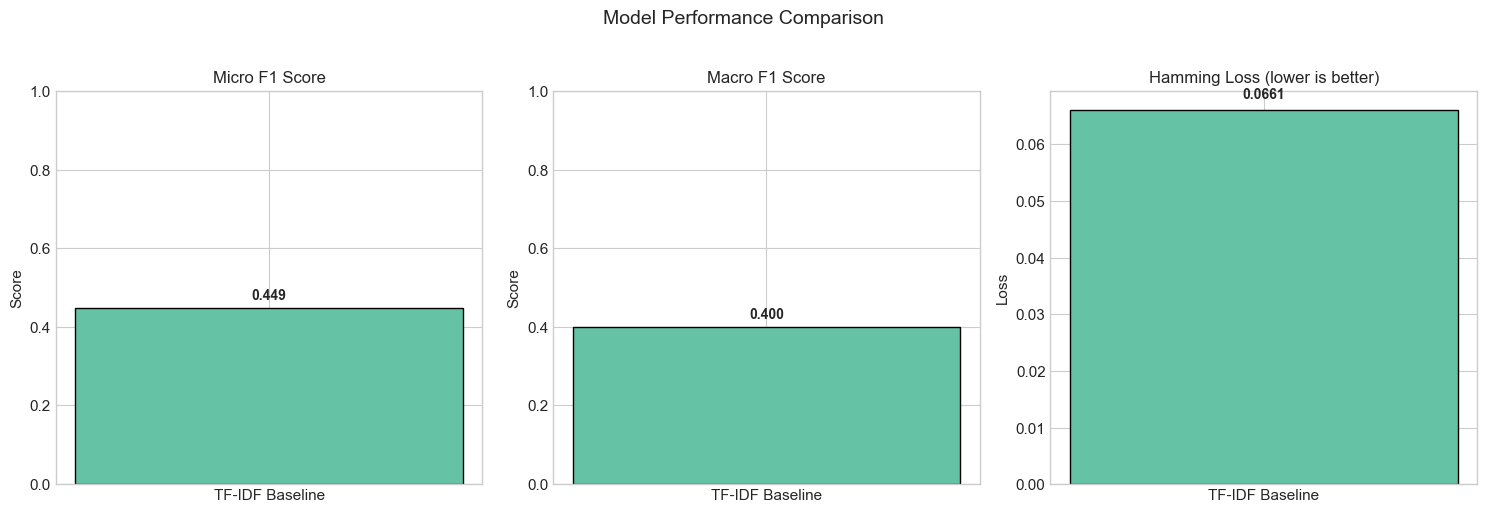

In [34]:
# Create bar chart comparison
if len(all_model_metrics) >= 1:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    model_names = list(all_model_metrics.keys())
    colors = plt.cm.Set2(np.linspace(0, 1, len(model_names)))
    
    # Micro F1
    micro_f1_scores = [all_model_metrics[m].get('micro_f1', 0) for m in model_names]
    bars1 = axes[0].bar(model_names, micro_f1_scores, color=colors, edgecolor='black')
    axes[0].set_ylabel('Score', fontsize=11)
    axes[0].set_title('Micro F1 Score', fontsize=12)
    axes[0].set_ylim(0, 1)
    for bar, score in zip(bars1, micro_f1_scores):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                     f'{score:.3f}', ha='center', fontsize=10, fontweight='bold')
    
    # Macro F1
    macro_f1_scores = [all_model_metrics[m].get('macro_f1', 0) for m in model_names]
    bars2 = axes[1].bar(model_names, macro_f1_scores, color=colors, edgecolor='black')
    axes[1].set_ylabel('Score', fontsize=11)
    axes[1].set_title('Macro F1 Score', fontsize=12)
    axes[1].set_ylim(0, 1)
    for bar, score in zip(bars2, macro_f1_scores):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                     f'{score:.3f}', ha='center', fontsize=10, fontweight='bold')
    
    # Hamming Loss (lower is better)
    hamming_scores = [all_model_metrics[m].get('hamming_loss', 0) for m in model_names]
    bars3 = axes[2].bar(model_names, hamming_scores, color=colors, edgecolor='black')
    axes[2].set_ylabel('Loss', fontsize=11)
    axes[2].set_title('Hamming Loss (lower is better)', fontsize=12)
    for bar, score in zip(bars3, hamming_scores):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
                     f'{score:.4f}', ha='center', fontsize=10, fontweight='bold')
    
    plt.suptitle('Model Performance Comparison', fontsize=14, y=1.02)
    plt.tight_layout()
    save_figure('model_comparison.png')
    plt.show()
else:
    print("Only one model available. Need at least 2 models for comparison chart.")

## 22. Per-class F1 Comparison

Saved: ../screenshots/perclass_f1_comparison.png


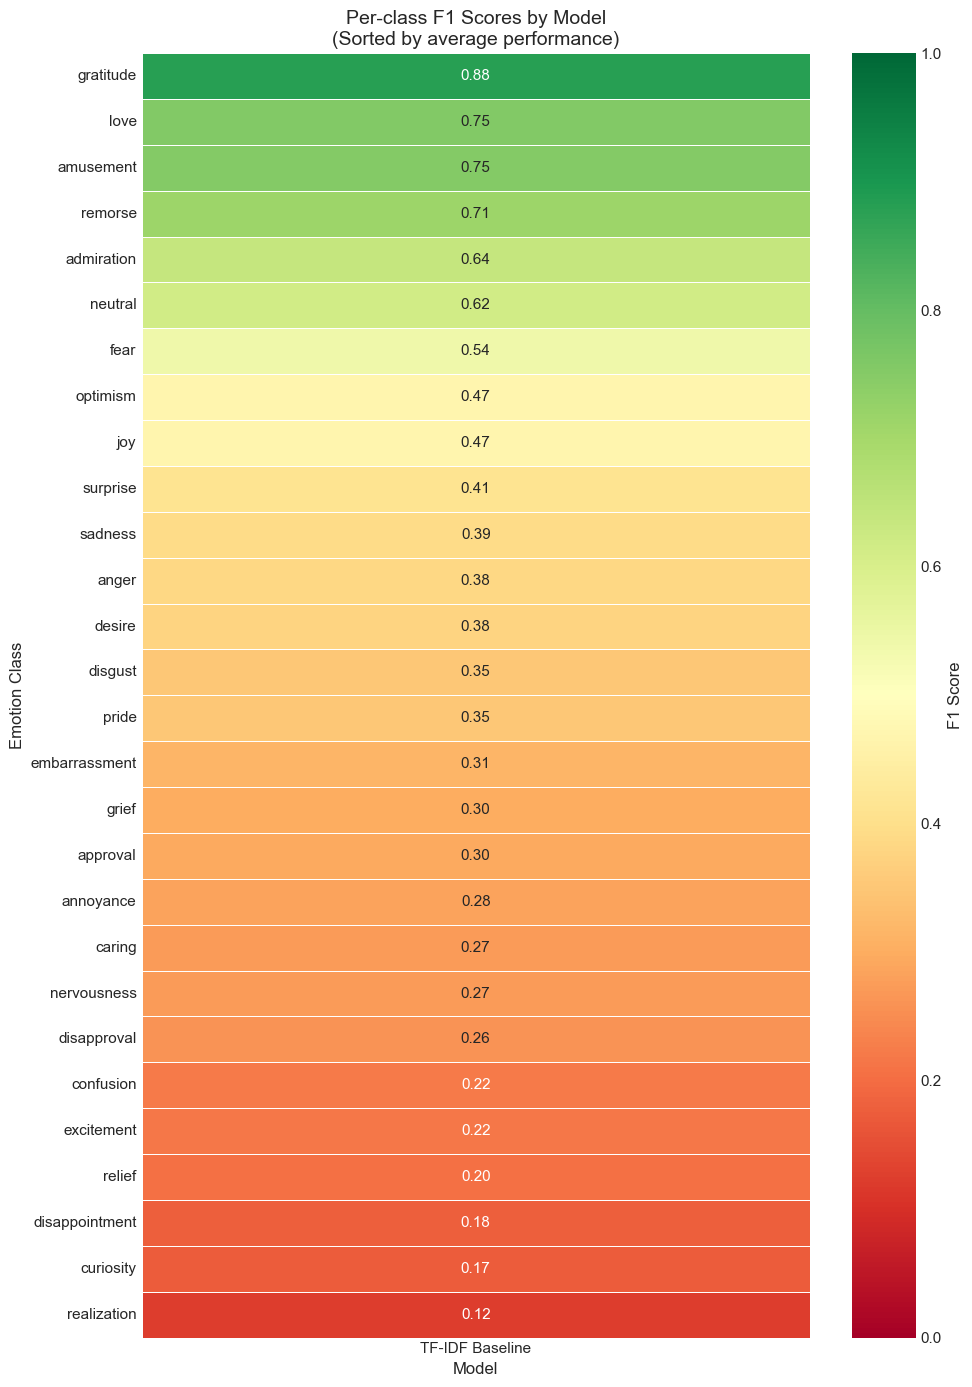


Classes with highest F1 (across models):
  gratitude      : 0.879
  love           : 0.754
  amusement      : 0.750
  remorse        : 0.714
  admiration     : 0.638

Classes with lowest F1 (across models):
  excitement     : 0.216
  relief         : 0.205
  disappointment : 0.179
  curiosity      : 0.173
  realization    : 0.123


In [35]:
# Per-class F1 comparison heatmap
models_with_perclass = {k: v for k, v in all_model_metrics.items() if 'per_class_f1' in v}

if models_with_perclass:
    # Create DataFrame for heatmap
    perclass_data = {}
    for model_name, metrics in models_with_perclass.items():
        perclass_data[model_name] = metrics['per_class_f1']
    
    perclass_df = pd.DataFrame(perclass_data)
    
    # Sort by average F1 score
    perclass_df['mean'] = perclass_df.mean(axis=1)
    perclass_df = perclass_df.sort_values('mean', ascending=False)
    perclass_df = perclass_df.drop('mean', axis=1)
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 14))
    
    sns.heatmap(
        perclass_df,
        annot=True,
        fmt='.2f',
        cmap='RdYlGn',
        vmin=0,
        vmax=1,
        linewidths=0.5,
        cbar_kws={'label': 'F1 Score'},
        ax=ax
    )
    
    ax.set_title('Per-class F1 Scores by Model\n(Sorted by average performance)', fontsize=14)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Emotion Class', fontsize=12)
    
    plt.tight_layout()
    save_figure('perclass_f1_comparison.png')
    plt.show()
    
    # Print best and worst classes
    print("\nClasses with highest F1 (across models):")
    top_classes = perclass_df.mean(axis=1).head(5)
    for cls, score in top_classes.items():
        print(f"  {cls:15s}: {score:.3f}")
    
    print("\nClasses with lowest F1 (across models):")
    bottom_classes = perclass_df.mean(axis=1).tail(5)
    for cls, score in bottom_classes.items():
        print(f"  {cls:15s}: {score:.3f}")
else:
    print("No per-class F1 data available for comparison.")

## 23. Feature Importance (TF-IDF)

FEATURE IMPORTANCE (TF-IDF Model)


Saved: ../screenshots/feature_importance.png


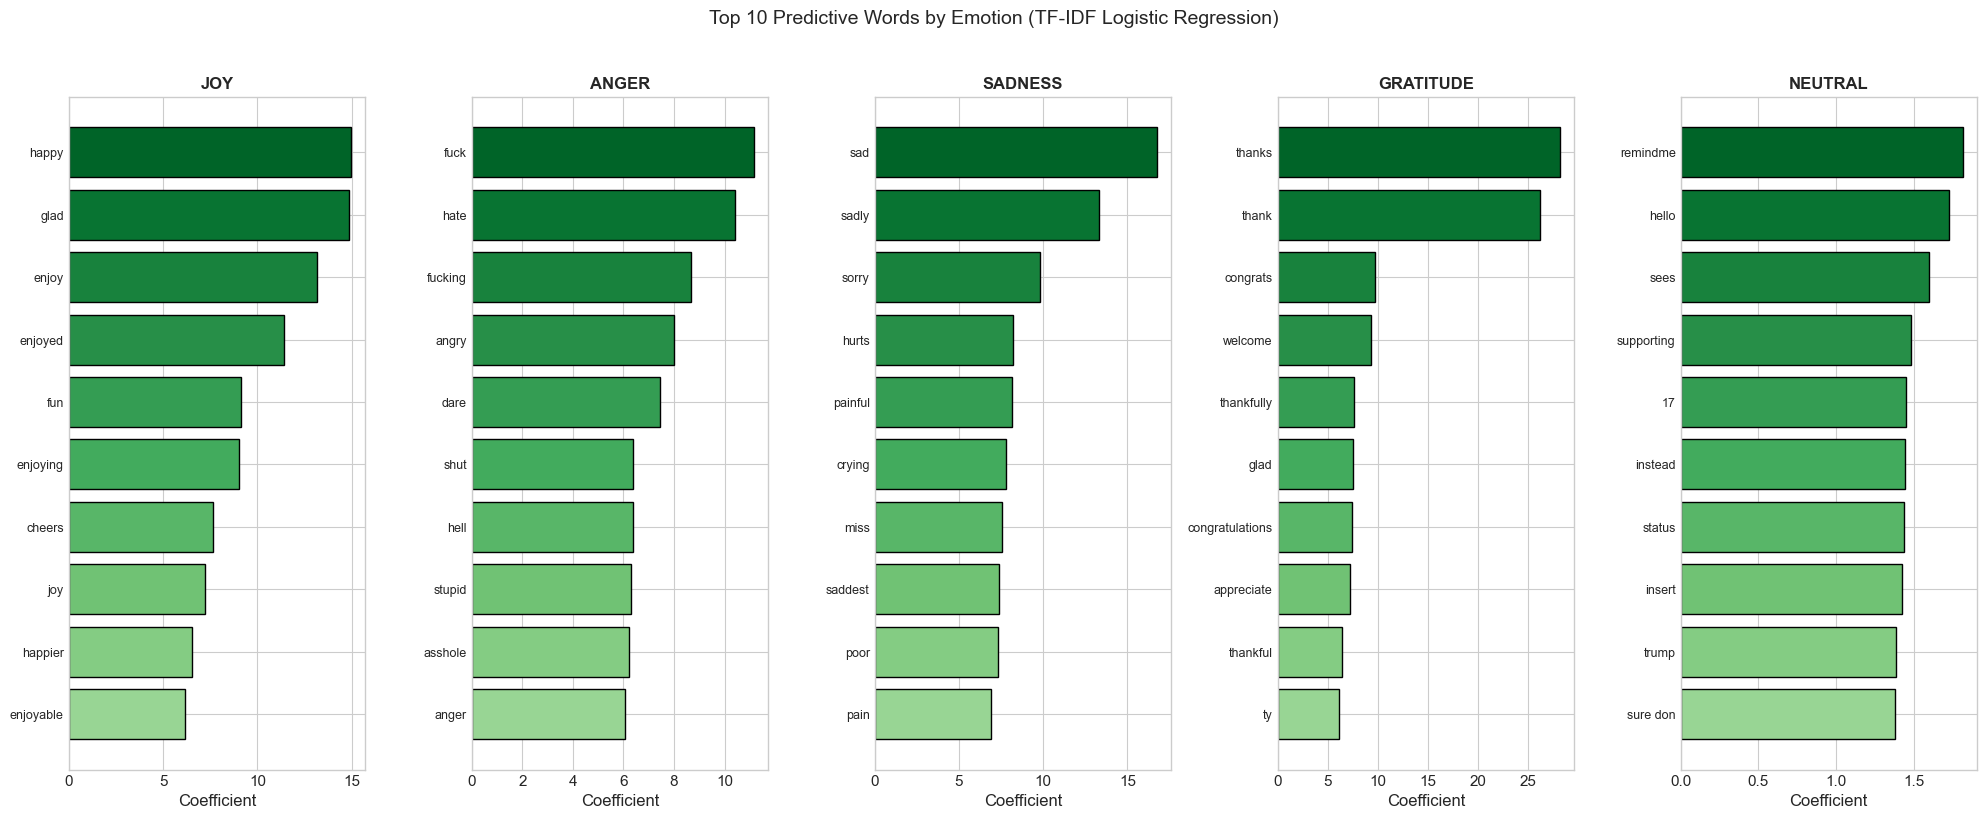

In [36]:
# Feature importance for TF-IDF model
if 'classifier' in dir() and hasattr(classifier, 'estimators_'):
    print("=" * 50)
    print("FEATURE IMPORTANCE (TF-IDF Model)")
    print("=" * 50)
    
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    # Get top features for selected emotions
    selected_emotions = ['joy', 'anger', 'sadness', 'gratitude', 'neutral']
    
    fig, axes = plt.subplots(1, len(selected_emotions), figsize=(20, 8))
    
    for idx, emotion in enumerate(selected_emotions):
        emotion_idx = LABEL2ID[emotion]
        
        # Get coefficients for this emotion's classifier
        if hasattr(classifier.estimators_[emotion_idx], 'coef_'):
            coefs = classifier.estimators_[emotion_idx].coef_[0]
            
            # Top positive features
            top_positive_idx = np.argsort(coefs)[-10:]
            top_features = feature_names[top_positive_idx]
            top_weights = coefs[top_positive_idx]
            
            # Plot
            colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_features)))
            axes[idx].barh(range(len(top_features)), top_weights, color=colors, edgecolor='black')
            axes[idx].set_yticks(range(len(top_features)))
            axes[idx].set_yticklabels(top_features, fontsize=9)
            axes[idx].set_xlabel('Coefficient')
            axes[idx].set_title(f'{emotion.upper()}', fontsize=12, fontweight='bold')
    
    plt.suptitle('Top 10 Predictive Words by Emotion (TF-IDF Logistic Regression)', fontsize=14, y=1.02)
    plt.tight_layout()
    save_figure('feature_importance.png')
    plt.show()
else:
    print("TF-IDF classifier not available for feature importance analysis.")

---

# Part 6: Conclusions

## 24. Summary and Recommendations

In [37]:
print("=" * 70)
print("PROJECT SUMMARY AND RECOMMENDATIONS")
print("=" * 70)

# Determine best model
if all_model_metrics:
    best_model_name = max(all_model_metrics.items(), key=lambda x: x[1].get('macro_f1', 0))[0]
    best_metrics = all_model_metrics[best_model_name]
else:
    best_model_name = "N/A"
    best_metrics = {}

summary = f"""
1. DATASET SUMMARY
   - Total samples: {len(train_df) + len(val_df) + len(test_df):,}
   - Number of emotion classes: {NUM_LABELS}
   - Multi-label: Yes (avg {labels_per_sample.mean():.2f} labels/sample)
   - Class imbalance: {class_counts.values[-1] / class_counts.values[0]:.1f}x ratio

2. MODELS EVALUATED
   - TF-IDF + Logistic Regression (baseline)
   - RoBERTa-base fine-tuned
   - DeBERTa-v3-large fine-tuned (if CUDA available)

3. BEST MODEL: {best_model_name}
   - Micro F1:     {best_metrics.get('micro_f1', 'N/A')}
   - Macro F1:     {best_metrics.get('macro_f1', 'N/A')}
   - Hamming Loss: {best_metrics.get('hamming_loss', 'N/A')}

4. KEY FINDINGS
   - Transformer models significantly outperform TF-IDF baseline
   - Threshold optimization improves multi-label predictions
   - Class imbalance handling (weighted loss) is crucial
   - Rare emotions (grief, relief) remain challenging

5. RECOMMENDATIONS
   - For production: Use RoBERTa (good balance of speed/quality)
   - For maximum quality: Use DeBERTa with CUDA GPU
   - Consider ensemble methods for rare emotion classes
   - Implement confidence thresholding for uncertain predictions
"""

print(summary)

PROJECT SUMMARY AND RECOMMENDATIONS

1. DATASET SUMMARY
   - Total samples: 54,263
   - Number of emotion classes: 28
   - Multi-label: Yes (avg 1.18 labels/sample)
   - Class imbalance: 184.7x ratio

2. MODELS EVALUATED
   - TF-IDF + Logistic Regression (baseline)
   - RoBERTa-base fine-tuned
   - DeBERTa-v3-large fine-tuned (if CUDA available)

3. BEST MODEL: TF-IDF Baseline
   - Micro F1:     0.4486504279131007
   - Macro F1:     0.4002589212912338
   - Hamming Loss: 0.06614975514717497

4. KEY FINDINGS
   - Transformer models significantly outperform TF-IDF baseline
   - Threshold optimization improves multi-label predictions
   - Class imbalance handling (weighted loss) is crucial
   - Rare emotions (grief, relief) remain challenging

5. RECOMMENDATIONS
   - For production: Use RoBERTa (good balance of speed/quality)
   - For maximum quality: Use DeBERTa with CUDA GPU
   - Consider ensemble methods for rare emotion classes
   - Implement confidence thresholding for uncertain predi

## 25. Next Steps

In [38]:
print("=" * 70)
print("NEXT STEPS")
print("=" * 70)

print("""
1. MODEL DEPLOYMENT
   - FastAPI server: python -m src.predict.api
   - Docker: docker build -t goemotions . && docker run -p 8000:8000 goemotions

2. FULL TRAINING (if not done)
   - TF-IDF:  python -m src.train.train --model tfidf
   - RoBERTa: python -m src.train.train --model roberta --epochs 3
   - DeBERTa: python -m src.train.train --model deberta --epochs 3 (CUDA required)
   - All:     python -m src.train.train --model all

3. EVALUATION ON TEST SET
   - Load test data and run predictions with best model
   - Report final metrics on held-out test set

4. POTENTIAL IMPROVEMENTS
   - Data augmentation for rare classes
   - Ensemble of multiple models
   - Hyperparameter optimization with Optuna
   - Label smoothing for better calibration

5. SCREENSHOTS GENERATED
""")

# List generated screenshots
import os
screenshots = list(SCREENSHOTS_DIR.glob('*.png'))
if screenshots:
    print(f"   Generated {len(screenshots)} visualization(s):")
    for f in sorted(screenshots):
        print(f"   - {f.name}")
else:
    print("   No screenshots generated yet.")

NEXT STEPS

1. MODEL DEPLOYMENT
   - FastAPI server: python -m src.predict.api
   - Docker: docker build -t goemotions . && docker run -p 8000:8000 goemotions

2. FULL TRAINING (if not done)
   - TF-IDF:  python -m src.train.train --model tfidf
   - RoBERTa: python -m src.train.train --model roberta --epochs 3
   - DeBERTa: python -m src.train.train --model deberta --epochs 3 (CUDA required)
   - All:     python -m src.train.train --model all

3. EVALUATION ON TEST SET
   - Load test data and run predictions with best model
   - Report final metrics on held-out test set

4. POTENTIAL IMPROVEMENTS
   - Data augmentation for rare classes
   - Ensemble of multiple models
   - Hyperparameter optimization with Optuna
   - Label smoothing for better calibration

5. SCREENSHOTS GENERATED

   Generated 10 visualization(s):
   - eda_class_distribution.png
   - eda_cooccurrence.png
   - eda_labels_per_sample.png
   - eda_missing_values.png
   - eda_text_length.png
   - eda_wordclouds.png
   - fe

In [39]:
print("\n" + "=" * 70)
print("NOTEBOOK COMPLETED SUCCESSFULLY")
print("=" * 70)
print(f"\nTimestamp: {datetime.now().isoformat()}")


NOTEBOOK COMPLETED SUCCESSFULLY

Timestamp: 2026-02-02T22:47:07.488712
